In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib as mpl
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
#import socket
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
# def running_mean(X,n=10):
#     return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
# #

In [3]:
# import socket
# socket.gethostname()

In [4]:
n_cpus = 4
#print('** epoch: {}'.format(mpd.get_epoch()))
if 'SLURM_CPUS_PER_TASK' in os.environ.keys():
    n_cpus = int(os.environ['SLURM_CPUS_PER_TASK'])
#
print(f'*** n_cpus: {n_cpus}')

*** n_cpus: 4


In [5]:
N_report_len = 180
end_dtm = dtm.datetime(2023,11,14)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
#delim_sacct='|'
delim_sacct='*'
partition='serc'
#partition=None
group=None
s_user=None
verbose=0
# group='oneillm'
# group='edunham'
#s_user = 'labraha2'
#
sacct_h5_file = f'sacct_data/sacct_sherlock_p{str(partition).upper()}_g{str(group).upper()}_u{s_user}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file [{os.path.isfile(sacct_h5_file)}]: {sacct_h5_file}')

*** dates: 2023-05-18 - 2023-11-14
*** sacct_h5_file [True]: sacct_data/sacct_sherlock_pSERC_gNONE_uNone_20230518_20231114.h5


In [6]:
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose, delim=delim_sacct,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_sherlock_pSERC_gNONE_uNone_20230518_20231114.h5
**  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [7]:
SP=hpc_lib.SH_PART_obj()

In [8]:
print(f'*** Cols: {SACCT_obj.jobs_summary.dtype.names}')
print(f'*** CPUs: {SP.get_total_cpus(partitions="serc")}')
print(f'*** GPUs: {SP.get_total_gpus(partitions="serc")}')

*** Cols: ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')
*** CPUs: 9104
*** GPUs: 92


In [9]:
n_cpus_serc = SP.get_total_cpus(partitions='serc')
n_gpus_serc = SP.get_total_gpus(partitions='serc')
#
print(f'** n_cpus: {n_cpus_serc}, n_gpus: {n_gpus_serc}')
#
print('*** ', SP.SP)

** n_cpus: 9104, n_gpus: 92
***         partition_name partition_public  nodes_idle  nodes_total  \
normal         normal              yes           3          187   
bigmem         bigmem              yes           2            9   
gpu               gpu              yes           0           26   
dev               dev              yes           2            4   
hns               hns               no           0          105   
serc             serc               no           1          233   
owners         owners               no           7         1488   

        cpu_cores_idle  cpu_cores_total  cpu_cores_queued  gpus_idle  \
normal             584             5012              4405          0   
bigmem             202              504               960          0   
gpu                469              748               268         10   
dev                 98              104                 0         64   
hns                260             3728                 0          0  

In [10]:

print('** ', SACCT_obj.jobs_summary.dtype)
print('** ', type(SACCT_obj.jobs_summary['User'][0]))
#
# my_ary = numpy.array(len(SACCT_obj.jobs_summary), dtype=SACCT_obj.jobs_summary.dtype)
# print('** ', my_ary.dtype)
#
for cl,tp in SACCT_obj.jobs_summary.dtype.descr:
    print('** ', cl, tp)
    
#
print('** ** ', SACCT_obj.jobs_summary['Group'].astype(str)[0])


**  [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('Account', 'S8'), ('JobID', 'S77'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('ReqMem', '<f8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S64'), ('AllocTRES', 'S62'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 'S70'), ('NGPUs', '<i8')]
**  <class 'numpy.bytes_'>
**  index <i8
**  User ('|S8', {'h5py_encoding': 'ascii'})
**  Group ('|S8', {'h5py_encoding': 'ascii'})
**  GID ('|S6', {'h5py_encoding': 'ascii'})
**  Account ('|S8', {'h5py_encoding': 'ascii'})
**  JobID ('|S77', {'h5py_encoding': 'ascii'})


*** DEBUG t_now: 19688.41582528191, t_max: 19674.44693287037


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3737: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


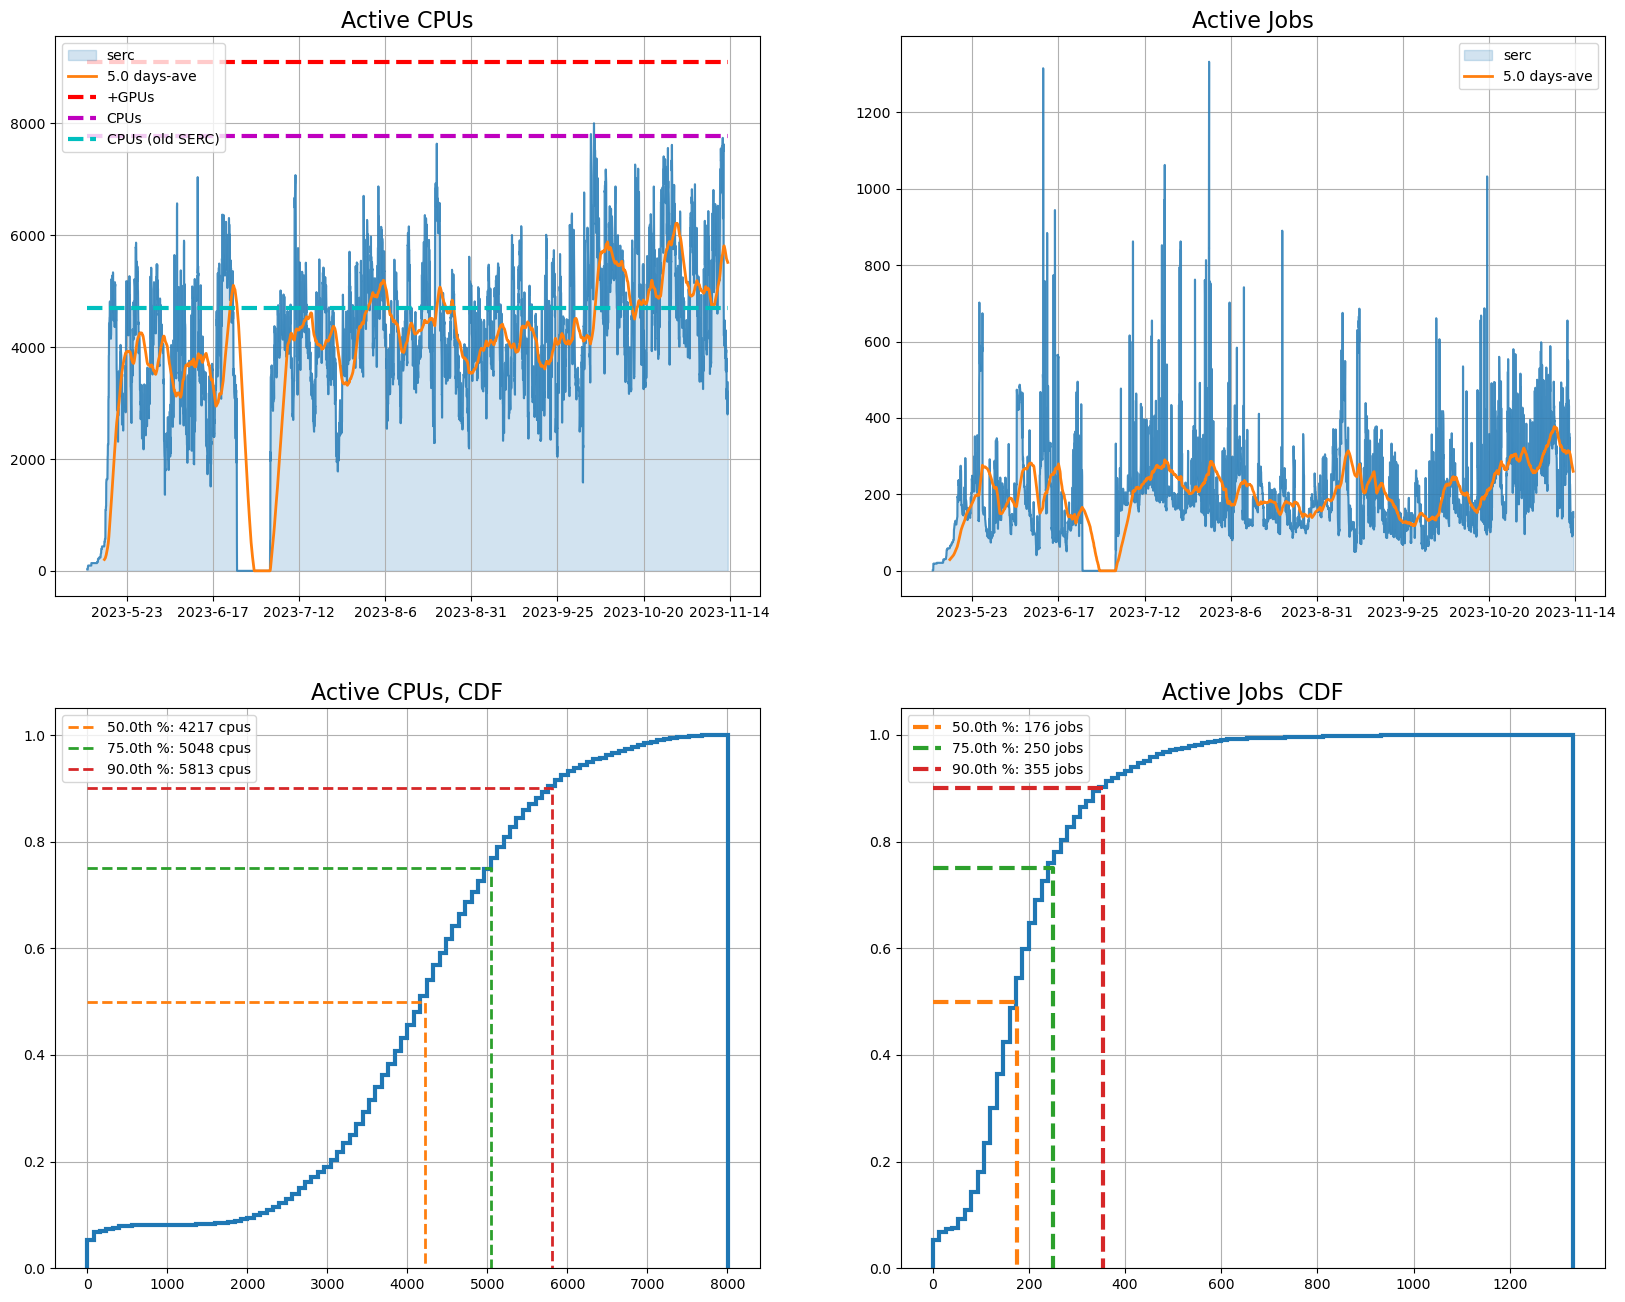

In [11]:
rep_cpu_lc = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Partition')
#
# plot total CPUs in partition. Also, subtract CPUs associated with GPUs. For now, this is just
#. something we know. we will need to work harder to get it from data.
ax = rep_cpu_lc.axes[0]
ln = ax.lines[0]
#
x_max_cpus = numpy.array([ax.lines[0].get_xdata()[0], ax.lines[0].get_xdata()[-1]])
ax.plot( x_max_cpus, numpy.ones(2)*n_cpus_serc, ls='--', lw=3.,
       color='r', label='+GPUs')

ax.plot( x_max_cpus, numpy.ones(2)*n_cpus_serc-(10*128 + 2*24), ls='--', lw=3.,
       color='m', label='CPUs')
#
ax.plot( x_max_cpus, numpy.ones(2)*n_cpus_serc-(10*128 + 2*24 + 96*32), ls='--', lw=3.,
       color='c', label='CPUs (old SERC)')

ax.legend(loc='upper left')

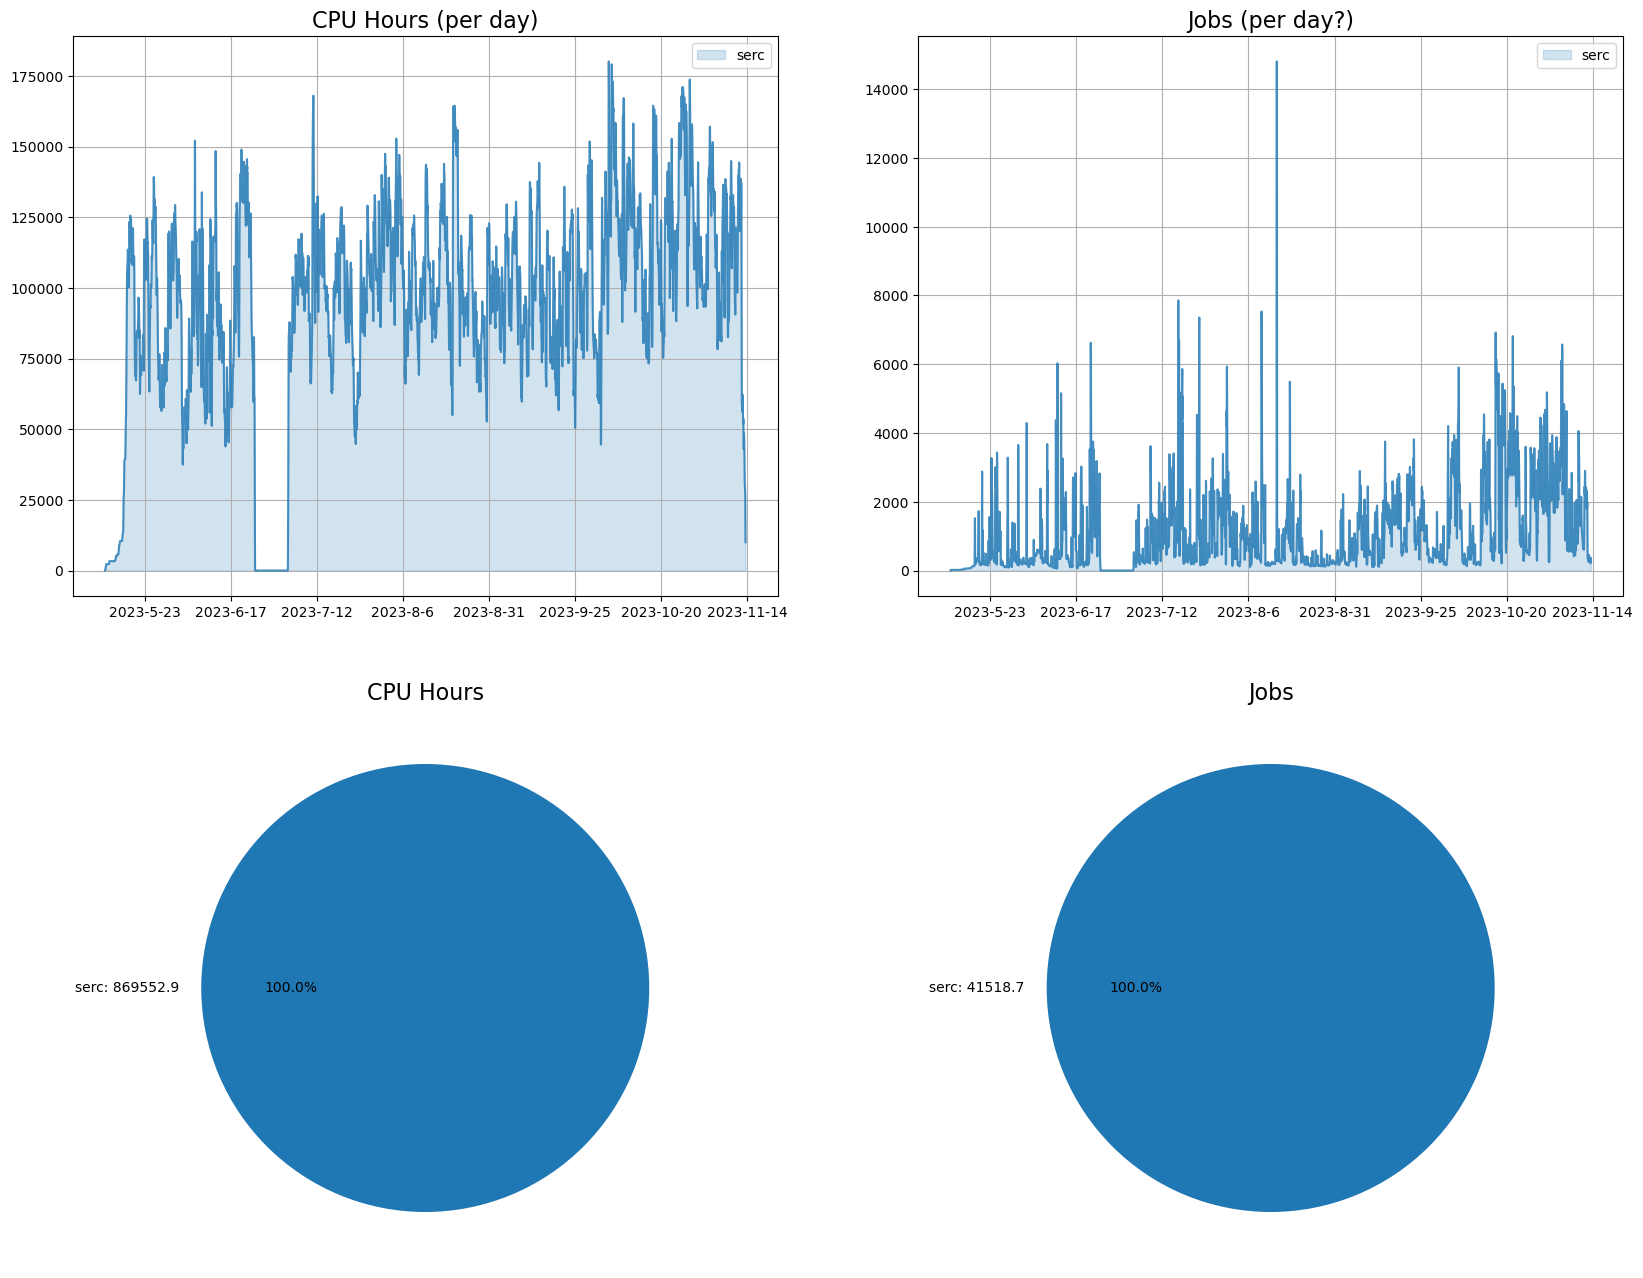

In [12]:
fg_cpuhlc = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Partition', autopct='%1.1f%%')

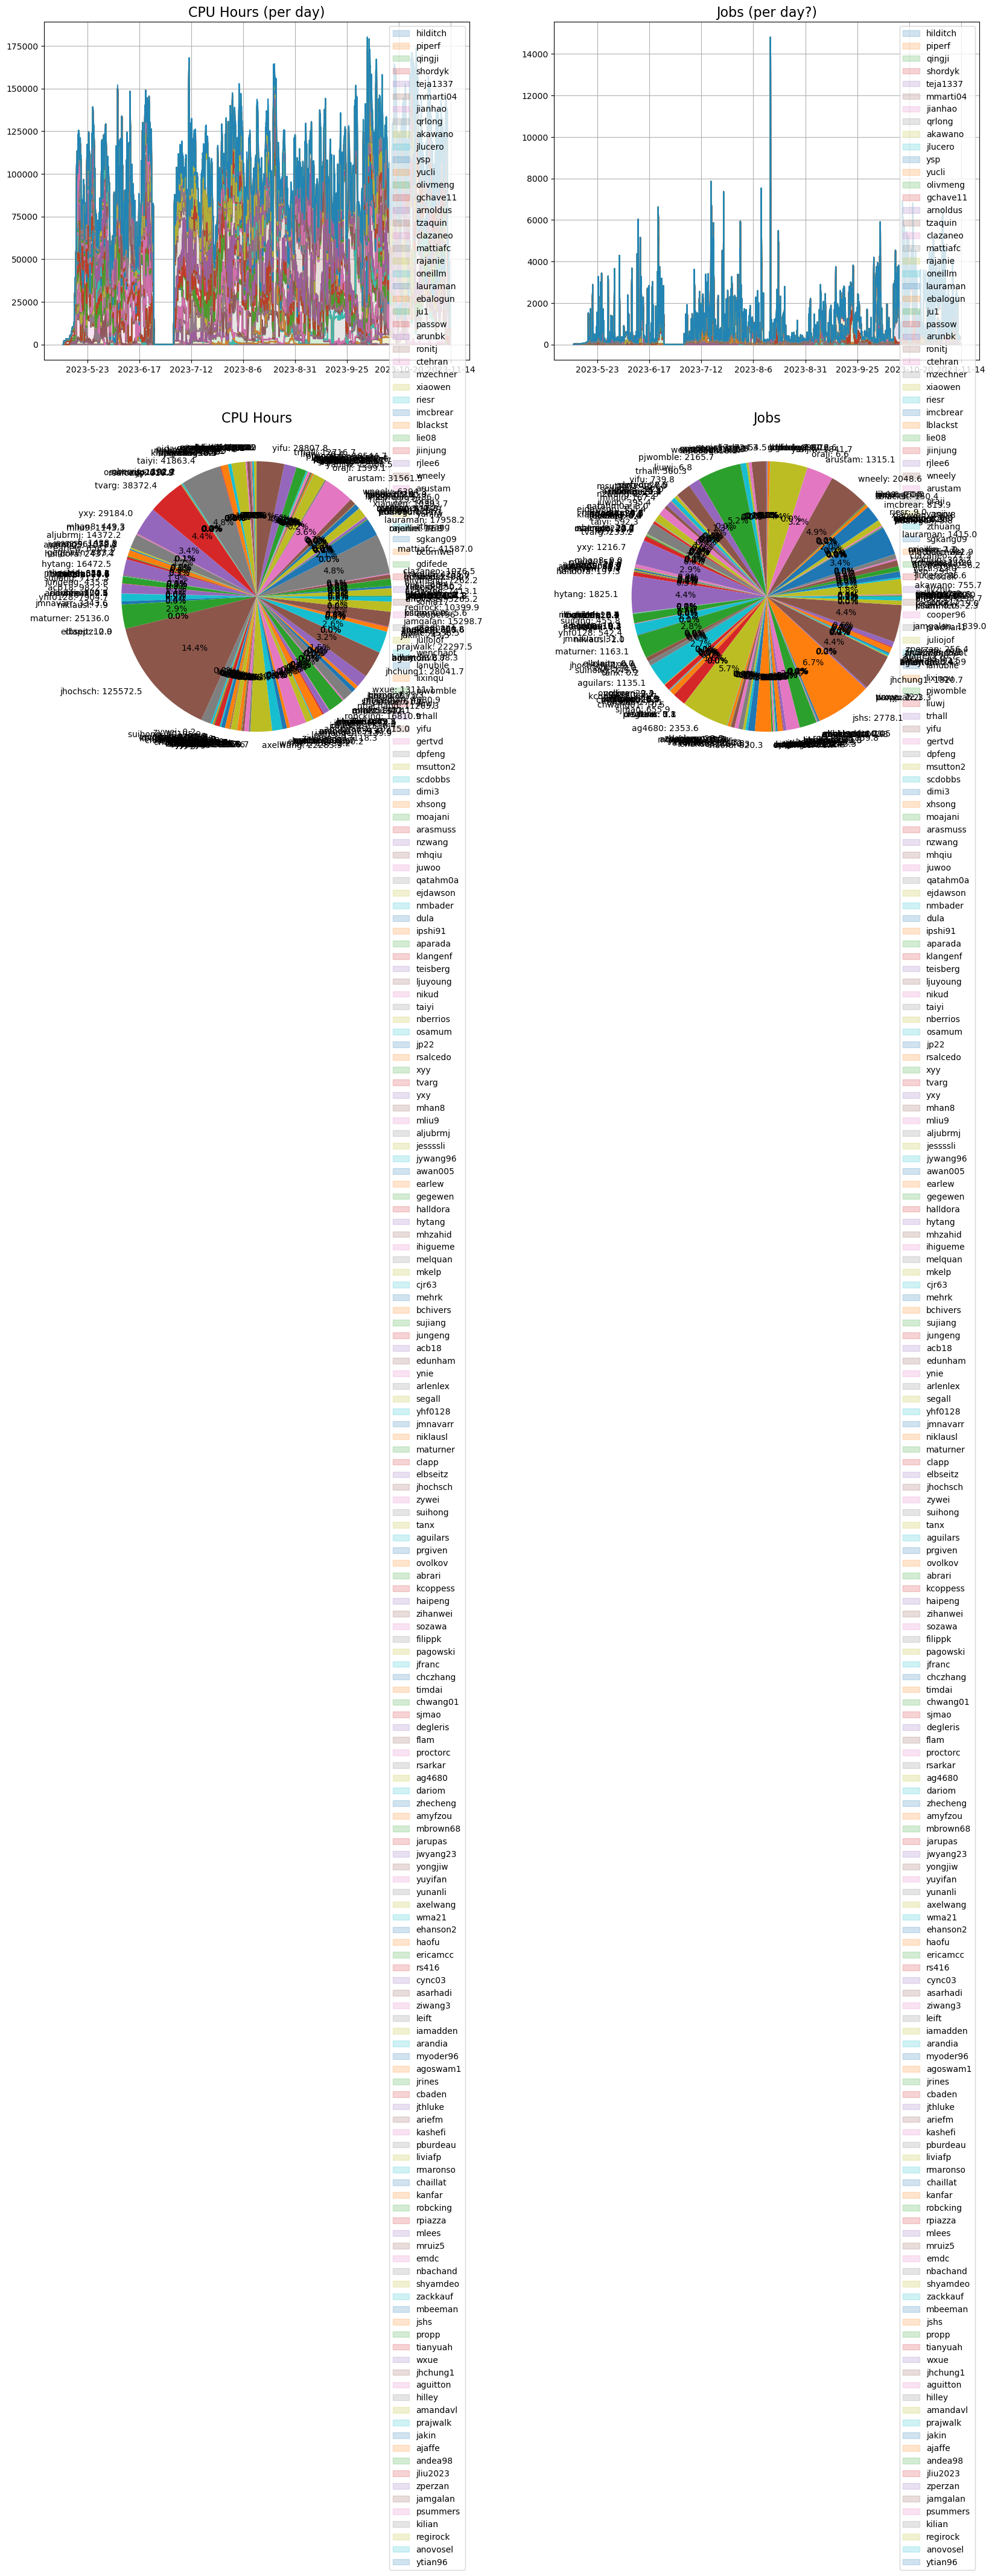

In [13]:
fg_cpuhl_u = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='User', autopct='%1.1f%%')

*** DEBUG t_now: 19688.41715773617, t_max: 19674.44693287037


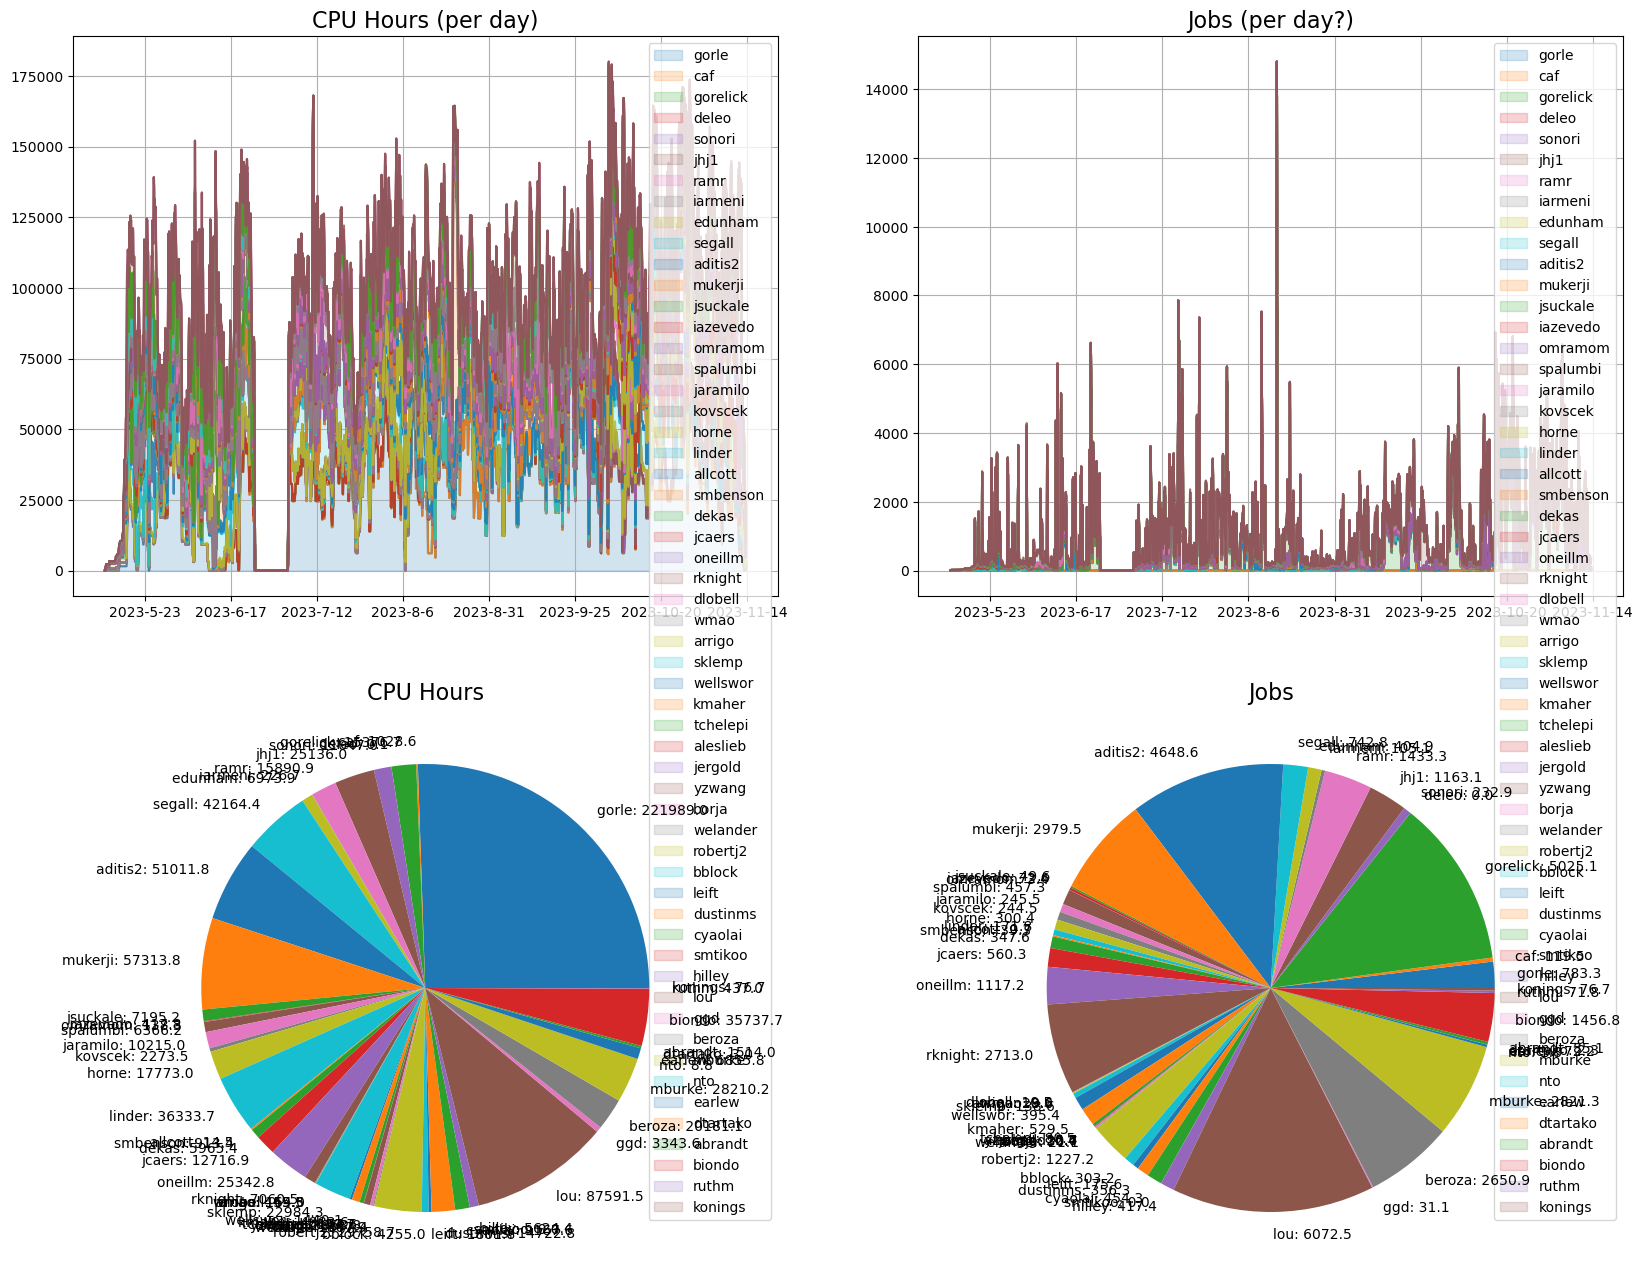

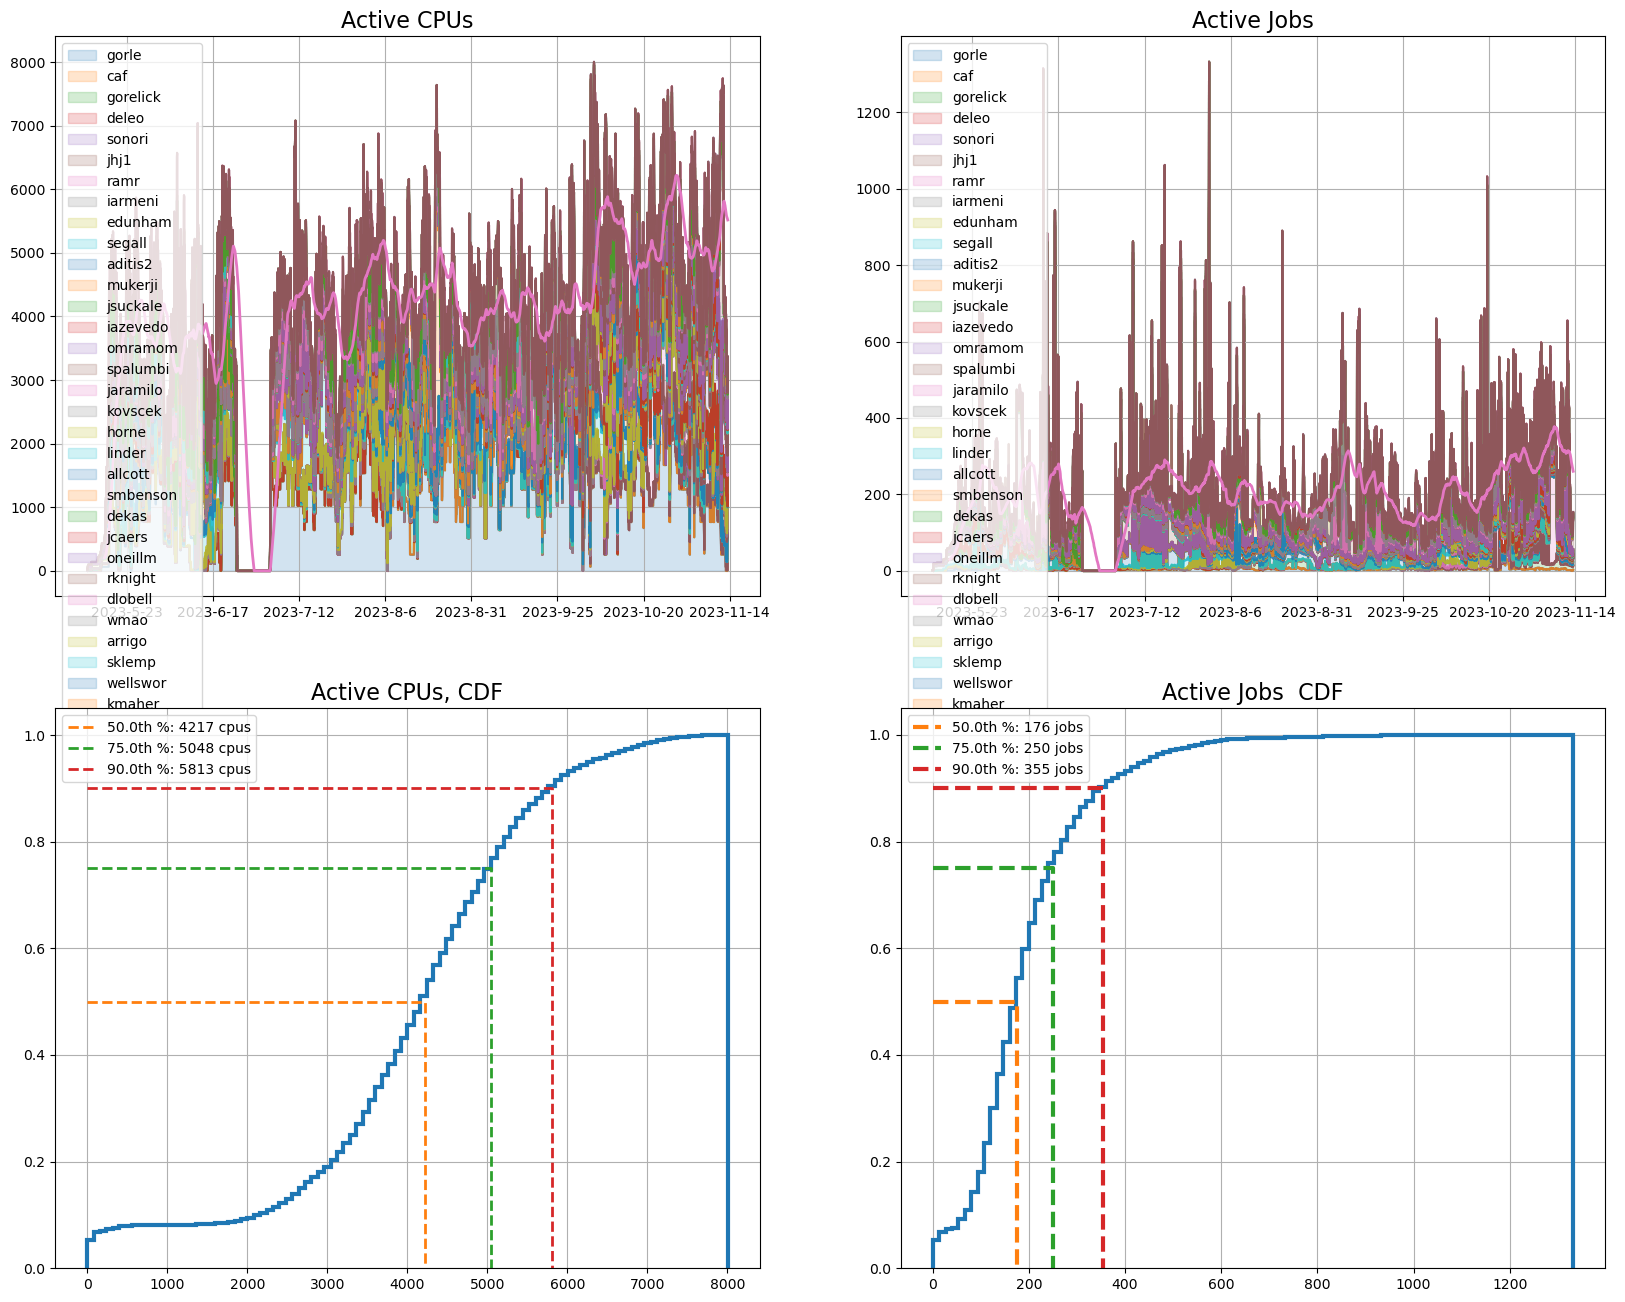

In [14]:
fg_cpuhl_acct = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Account')
fg_cpu_lc_acct = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Account')

### User stat table
- Generate a table of summary user stats

In [15]:
#
cpuh_pie_user = hpc_lib.get_pie_slices(sum_data=SACCT_obj['Elapsed']*SACCT_obj['NCPUS'],
                                       slice_data=SACCT_obj['User'])
jobs_pie_user = hpc_lib.get_pie_slices(sum_data=SACCT_obj['Elapsed'], slice_data=SACCT_obj['User'])
#

*** CPU-hours: 
Name;cpu-hours;job-hours;n_jobs;last_job_start;Group;Accounts;Partitions
jhochsch;125572.49583333333;199.91204861111112;419;2023-11-07 03:47:48+00:00;gorle;gorle;serc
taiyi;41863.359351851854;592.2928587962963;168;2023-10-20 13:51:57+00:00;segall;segall;serc
mattiafc;41587.00386574074;232.8682638888889;520;2023-11-13 10:43:35+00:00;gorle;gorle;serc
tvarg;38372.44;233.17122685185183;355;2023-11-13 08:54:03+00:00;gorle;gorle;serc
arustam;31561.459444444445;1315.0608101851853;2464;2023-11-12 20:01:46+00:00;biondo;biondo;serc
yxy;29183.960277777776;1216.6782291666668;495;2023-11-02 23:57:46+00:00;robertj2;robertj2;serc
yifu;28807.820983796293;739.7652893518518;1638;2023-11-10 12:48:46+00:00;lou;lou;serc
jhchung1;28041.7471875;1820.6853125;42265;2023-11-01 11:26:41+00:00;mukerji;mukerji;serc
maturner;25136.036273148147;1163.074224537037;3574;2023-10-26 20:14:23+00:00;jhj1;jhj1;serc
prajwalk;22297.466666666667;92.4675925925926;168;2023-11-03 16:04:04+00:00;linder;linder;serc


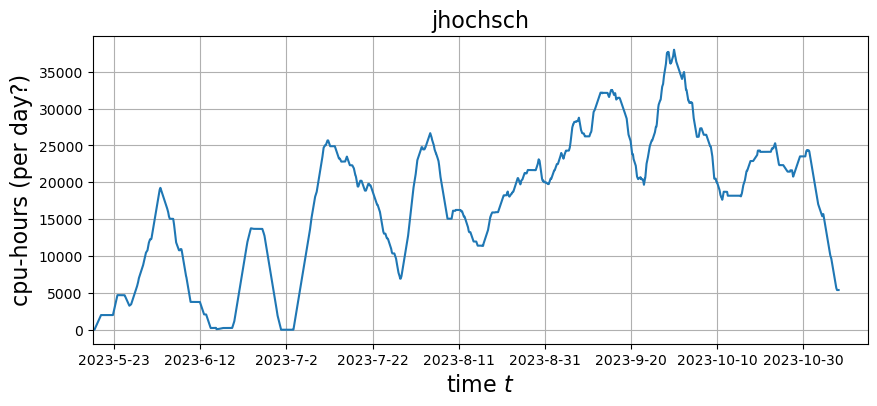

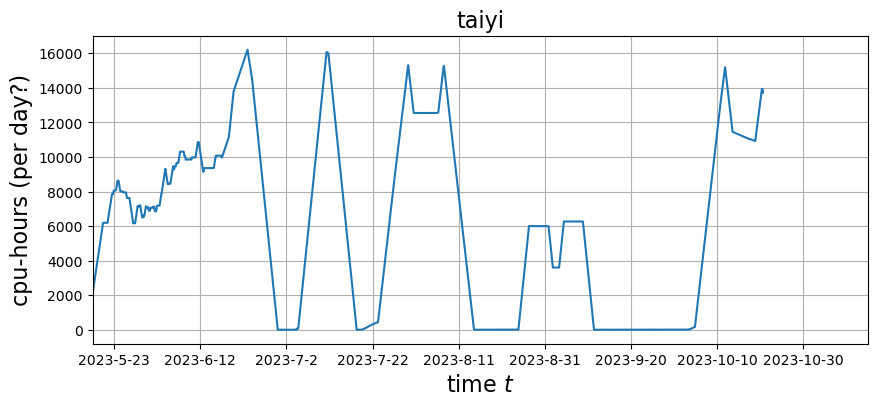

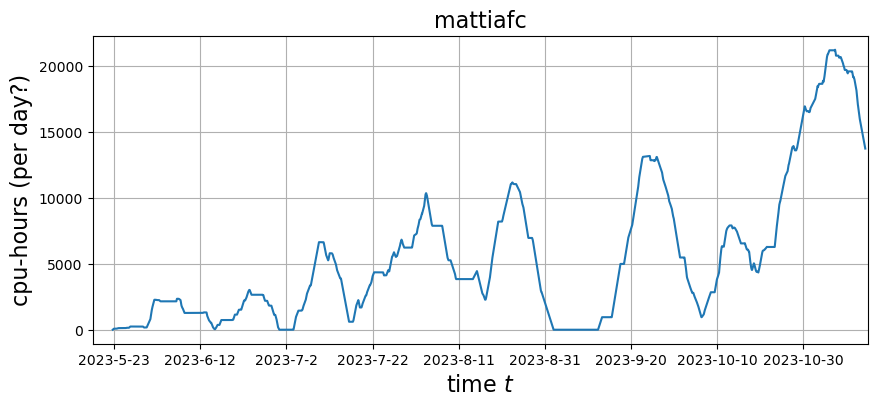

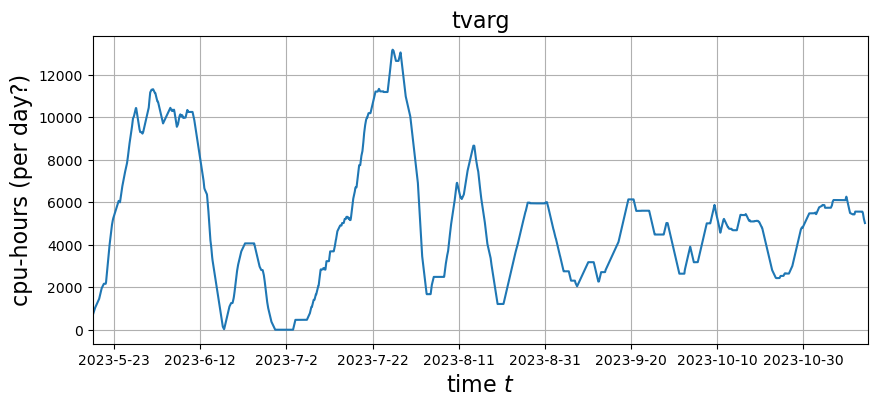

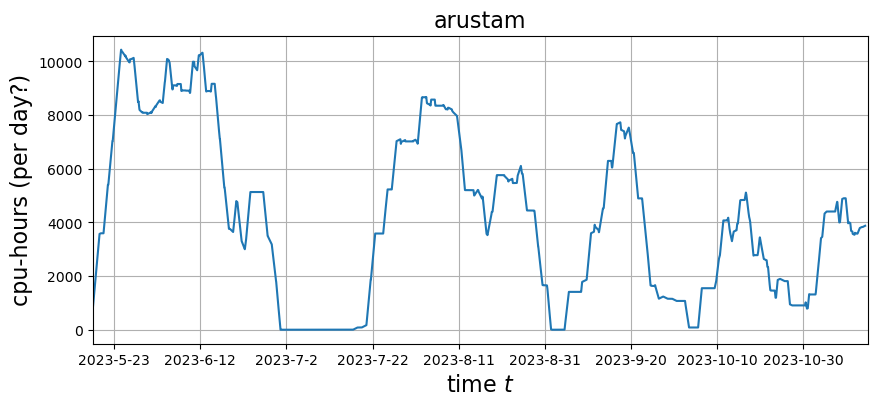

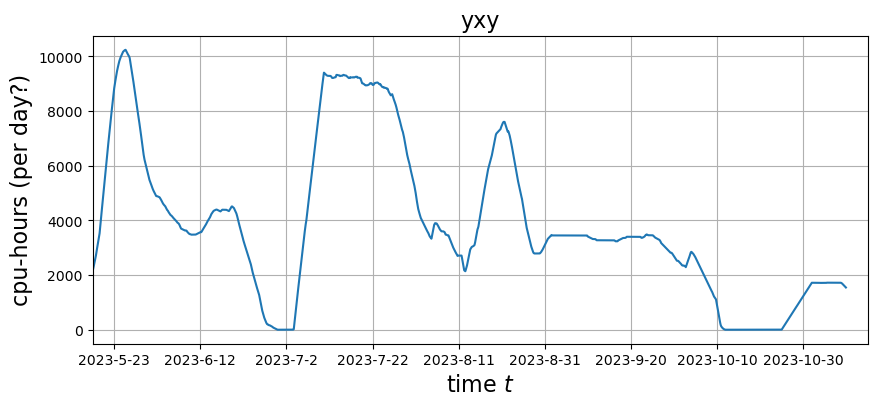

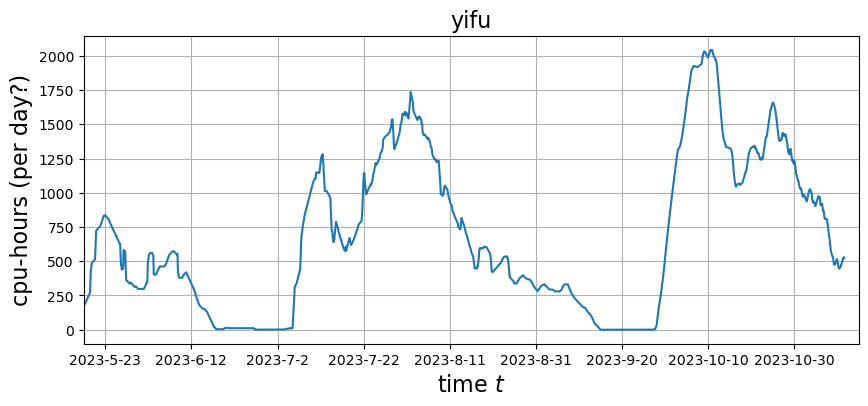

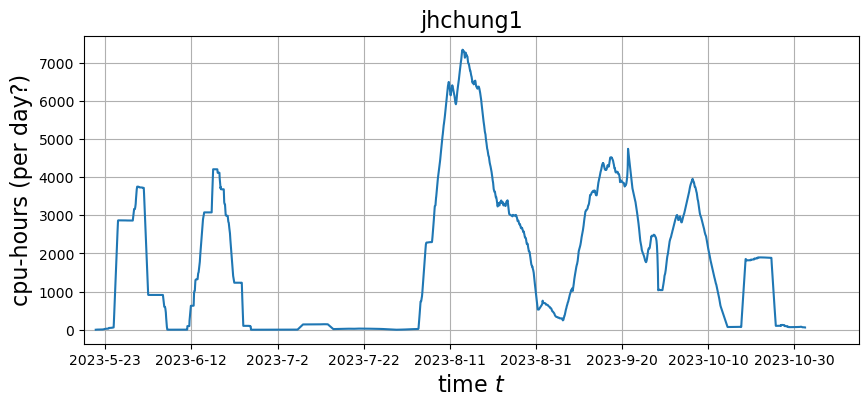

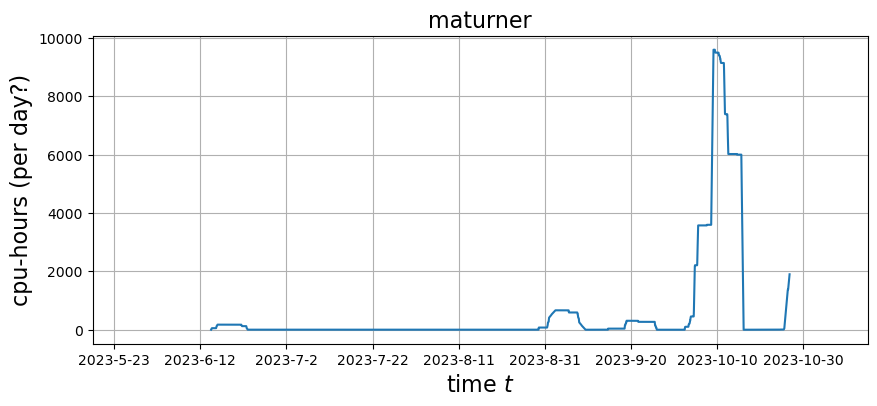

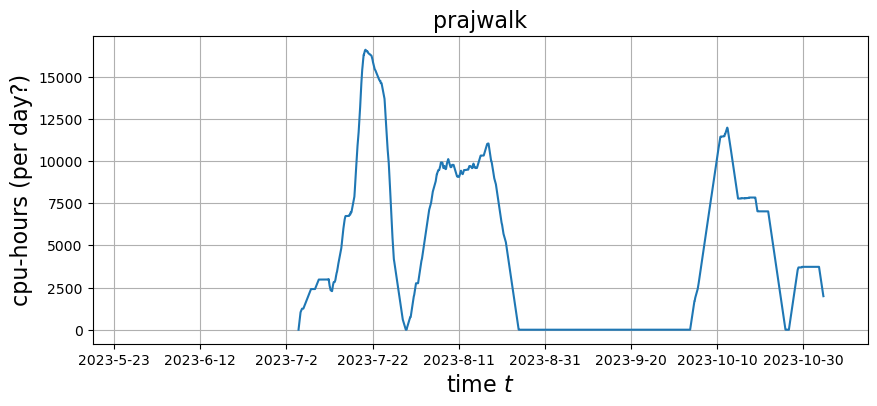

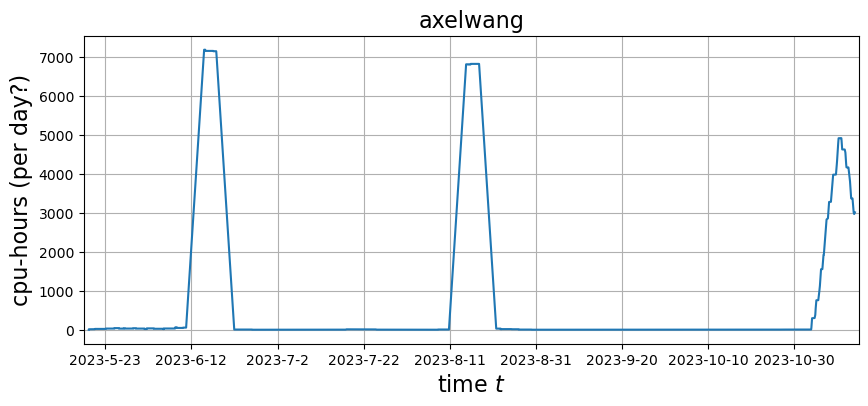

In [16]:
# This will be way too big to produce in notebooks, practically speaking at least..
# or maybe not, but we should do it last?
t0 = mpd.date2num(start_date)
t1 = mpd.date2num(end_date)
delim = chr(9)
delim = ';'
print('*** CPU-hours: ')
#print('**  Name,   cpu-hours,    job-hours,  last_job_start', )
print(delim.join(['Name', 'cpu-hours', 'job-hours', 'n_jobs', 'last_job_start', 'Group', 'Accounts', 'Partitions']))
jindex = {nm:k for k,nm in enumerate(jobs_pie_user['name'].astype(str))}
#print('** jindex: ', jindex)
for k, (nm,n) in enumerate(cpuh_pie_user[numpy.argsort(cpuh_pie_user['value'])[::-1]] ):
    if k>10: break
    #
    ix = SACCT_obj['User'].astype(type(nm)) == nm
    fg = plt.figure(figsize=(10,4))
    ax = fg.add_subplot(1,1,1)
    z = SACCT_obj.get_cpu_hours(jobs_summary=SACCT_obj[ix])
    ax.plot(z['time'], z['cpu_hours'], ls='-', marker='')
    ax.set_xlim(t0,t1)
    ax.grid()
    ax.set_xlabel('time $t$', size=16)
    ax.set_ylabel('cpu-hours (per day?)', size=16)
    #
    if isinstance(nm,bytes):
        nm = nm.decode()
    #
    ax.set_title(nm, size=16)
    #
    fg.canvas.draw()
    dt_epoch = hpc_lib.compute_mpd_epoch_dt(z['time'][0])
    lbls = [hpc_lib.simple_date_string(mpd.num2date(x + dt_epoch)) for x in ax.get_xticks()]
#     lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_value()))) + dt_epoch) )
#               for s in ax.get_xticklabels()]

    #
    #ax.set_xticklabels(lbls)
    # This should get rid of the FixedLocator warning? But I'm not sure it will...
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(lbls)
    #
    rw_vals = [nm, n, jobs_pie_user['value'][jindex[nm]], numpy.sum(ix).astype(int),\
          (None if numpy.isnan(numpy.nanmax(numpy.nanmax(SACCT_obj['Start'][ix]))) else mpd.num2date(numpy.nanmax(SACCT_obj['Start'][ix])) ),\
           SACCT_obj['Group'][ix].astype(str)[0],\
                ','.join(numpy.unique(SACCT_obj['Account'][ix]).astype(str)),\
                ','.join(numpy.unique(SACCT_obj['Partition'][ix]).astype(str))]
    print(delim.join([str(x) for x in rw_vals]))
#     print(f"{nm.decode()}, {n}, {jobs_pie_user['value'][jindex[nm]]},\
#           {mpd.num2date(max(SACCT_obj['Start'][ix]))}, {SACCT_obj['Group'][ix].astype(str)[0]},\
#                 {delim.join(numpy.unique(SACCT_obj['Account'][ix]).astype(str))},\
#                 {delim.join(numpy.unique(SACCT_obj['Partition'][ix]).astype(str))}\
#                 ")
#
# print('*** Jobs-time:')
# print('**  Name,   n_jobs,   last_job_start')
# for nm,n in jobs_pie_user[numpy.argsort(jobs_pie_user['value'])[::-1]]:
#     ix = SACCT_obj['User'].astype(type(nm)) == nm
#     print(f"**  {nm.decode()}, {n}, {mpd.num2date(max(SACCT_obj['Start'][ix]))}, {SACCT_obj['Group'][ix][0]}")

In [17]:
print('** ', ax)
print('** ', ax.get_xticklabels()[0].get_position()[0])
print('** ', ax.get_xticks())

**  Axes(0.125,0.11;0.775x0.77)
**  19480.0
**  [19480. 19500. 19520. 19540. 19560. 19580. 19600. 19620. 19640. 19660.
 19680.]


In [18]:
# Now, let's get a some reports for specific users, namely Lauren and Eric's former student(s) to estimate
#. requirements for their successors.
#
# Also, TODO: layer cake for active_cpus ?
# NOTE: for up and coming "how busy is the queue?" reporting, something like this:
# squeue -p serc --Format=jobid,jobarrayid,partition,username,state,timeused,timeleft,allocnodes,numnodes,numcpus


In [19]:
cpuh_jobs = SACCT_obj.get_cpu_hours(bin_size=1., n_points=5000)

In [20]:
cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1.)

***  [('time', '>f8'), ('serc', '>f8')]
***  [19488.48023148 19488.51743226 19488.55463304 19488.59183382
 19488.6290346  19488.66623538 19488.70343616 19488.74063694
 19488.77783772 19488.81503851]


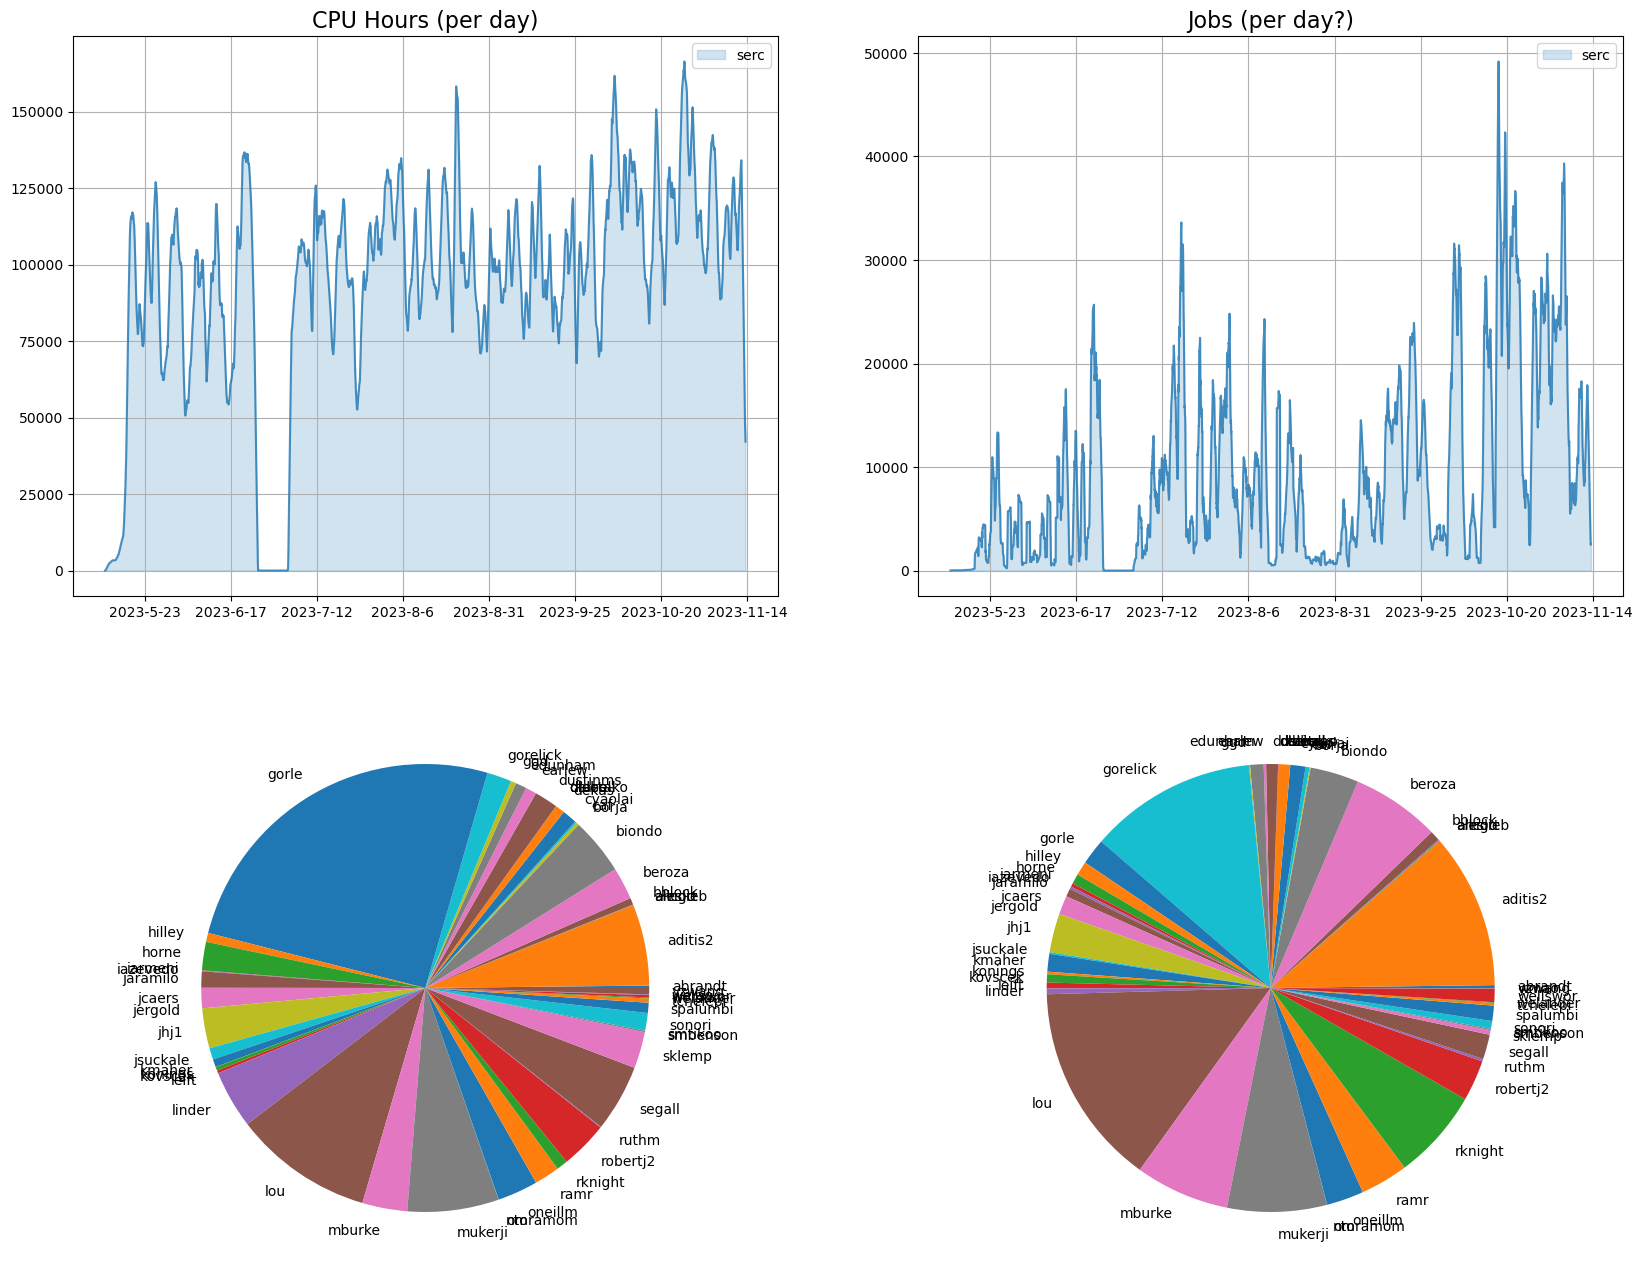

In [39]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
cpuh = cpuh_layers['cpu_hours']
jobs = cpuh_layers['jobs']
T = cpuh['time']

print('*** ', cpuh.dtype)
print('*** ', cpuh['time'][0:10])

#
z_cpuh = hpc_lib.plot_layer_cake(data=cpuh, layers=cpuh.dtype.names[1:], time_col='time', ax=ax1)
z_jobs = hpc_lib.plot_layer_cake(data=jobs, layers=cpuh.dtype.names[1:], time_col='time', ax=ax2)
#
# pi charts. left: cpu-hours, right job-time
pi_cpuh = hpc_lib.get_pie_slices(sum_data=SACCT_obj['Elapsed']*SACCT_obj['NCPUS'], slice_data=SACCT_obj['Account'])
pi_cpuh_lbls = pi_cpuh['name'].astype(str)
pi_cpuh_vls  = pi_cpuh['value'].astype(str)

pi_jobs = hpc_lib.get_pie_slices(sum_data=SACCT_obj['Elapsed'], slice_data=SACCT_obj['Account'])
pi_jobs_lbls = pi_jobs['name'].astype(str)
pi_jobs_vls  = pi_jobs['value'].astype(str)
#
ax3.pie(pi_cpuh_vls, labels=pi_cpuh_lbls)
ax4.pie(pi_jobs_vls, labels=pi_jobs_lbls)
#
ax1.legend(loc=0)
ax2.legend(loc=0)
#
# fg.canvas.draw()
# for ax in (ax1, ax2):
#     lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) + SACCT_obj.dt_mpd_epoch ) ) 
#              for s in ax.get_xticklabels()]
#     ax.set_xticklabels(lbls)
#fg.canvas.draw()
#lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text())))) ) 
#         for s in ax1.get_xticklabels()]
#ax1.set_xticklabels(lbls)


### SERC GPU activity

In [22]:
# serc_h5 = 'sacct_data/serc_sacct_20211126_20220525.h5'
# SACCT_serc = hpc_lib.SACCT_data_from_h5(serc_h5, keep_raw_data=False, n_cpu=n_cpus)

# serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
#                                                NCPUs=SACCT_serc.get_NGPUs())

SACCT_serc = SACCT_obj

### GPUs:
For now, hijack the SACCT.get_active_cpus_layer_cake() function, but force the "CPUs" column to use GPUs.

In [23]:
gpu_layers = SACCT_serc.get_active_cpus_layer_cake(layer_field='Account', NCPUs=SACCT_serc.get_NGPUs())

*** DEBUG t_now: 19688.418003437768, t_max: 19674.44693287037


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:721: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if NCPUs is None or NCPUs=='':


*** keys():  dict_keys(['N_cpu', 'N_jobs'])


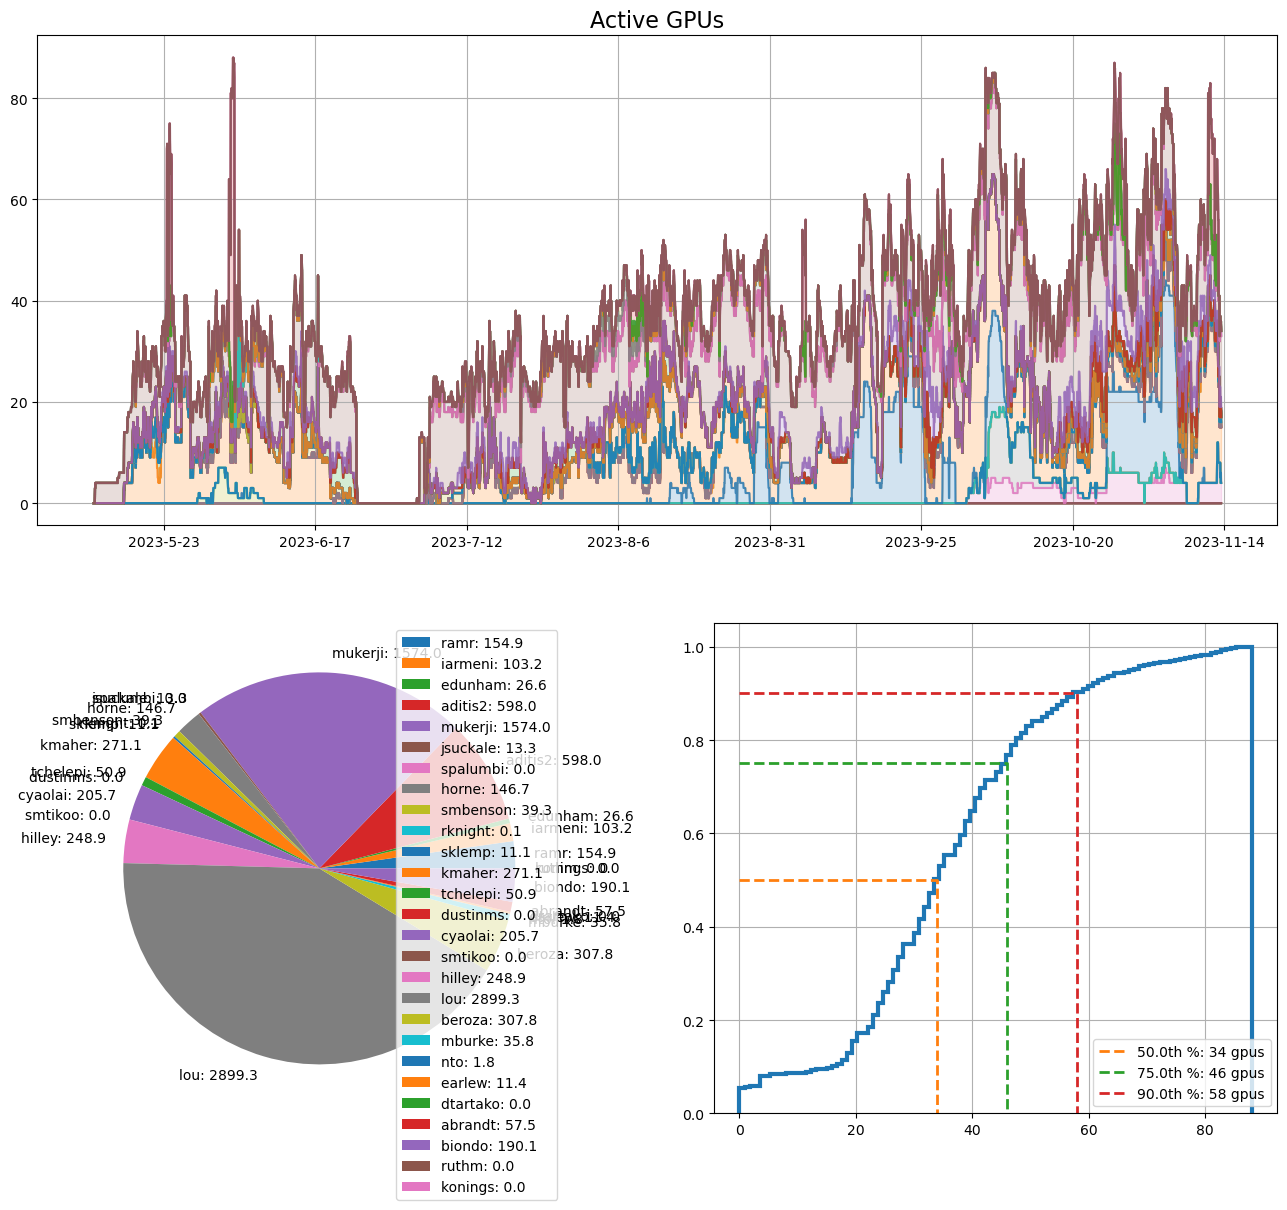

In [41]:
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
#print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_serc.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
#print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(16,14))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc='upper right')
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)


In [25]:
print('** ', gpu_layers['N_cpu'].dtype.names)

**  ('time', 'gorle', 'caf', 'gorelick', 'deleo', 'sonori', 'jhj1', 'ramr', 'iarmeni', 'edunham', 'segall', 'aditis2', 'mukerji', 'jsuckale', 'iazevedo', 'omramom', 'spalumbi', 'jaramilo', 'kovscek', 'horne', 'linder', 'allcott', 'smbenson', 'dekas', 'jcaers', 'oneillm', 'rknight', 'dlobell', 'wmao', 'arrigo', 'sklemp', 'wellswor', 'kmaher', 'tchelepi', 'aleslieb', 'jergold', 'yzwang', 'borja', 'welander', 'robertj2', 'bblock', 'leift', 'dustinms', 'cyaolai', 'smtikoo', 'hilley', 'lou', 'ggd', 'beroza', 'mburke', 'nto', 'earlew', 'dtartako', 'abrandt', 'biondo', 'ruthm', 'konings')


In [26]:
cpu_jobs_serc = SACCT_serc.active_jobs_cpu()


In [27]:
serc_cpu_qs = numpy.quantile(cpu_jobs_serc['N_cpu'], [.5, .75, .9])
print('** qs: ', serc_cpu_qs)

** qs:  [4172.5  4969.25 5660.2 ]


In [28]:
print('*** dtypes...: ', SACCT_obj.jobs_summary.dtype.names)

*** dtypes...:  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [29]:
print('*** ', SACCT_obj['ReqMem'][100:150])

***  [8.000e+09 8.000e+09 8.000e+09 8.000e+09 6.400e+10 2.500e+11 4.000e+12
 5.120e+11 5.120e+11 5.120e+11 1.200e+11 1.200e+11 1.600e+11 1.600e+11
 2.000e+09 1.200e+11 4.500e+12 1.200e+11 2.880e+11 1.600e+10 4.000e+09
 4.000e+09 3.200e+10 1.600e+12 1.600e+12 1.875e+11 2.400e+11 8.000e+09
 8.000e+09 1.875e+11 6.000e+10 8.000e+09 2.560e+11 8.000e+09 2.560e+11
 6.400e+10 1.600e+12 2.400e+12 2.400e+12 5.000e+10 8.000e+09 2.000e+10
 2.000e+10 6.400e+10 1.875e+11 4.000e+11 1.200e+11 1.200e+11 3.360e+11
 3.360e+11]


**  [ 0  1  2  3  4  5  6  7  8  9 10 12 15 20 29 32]
***  1693406 9045


/tmp/ipykernel_12981/247879298.py:11: RuntimeWarning: divide by zero encountered in divide
  mem_per_cpu = (SACCT_obj['ReqMem'][ix_cpu] / SACCT_obj['NCPUS'][ix_cpu])/10**9


Text(0.5, 1.0, 'ReqMem/GPU')

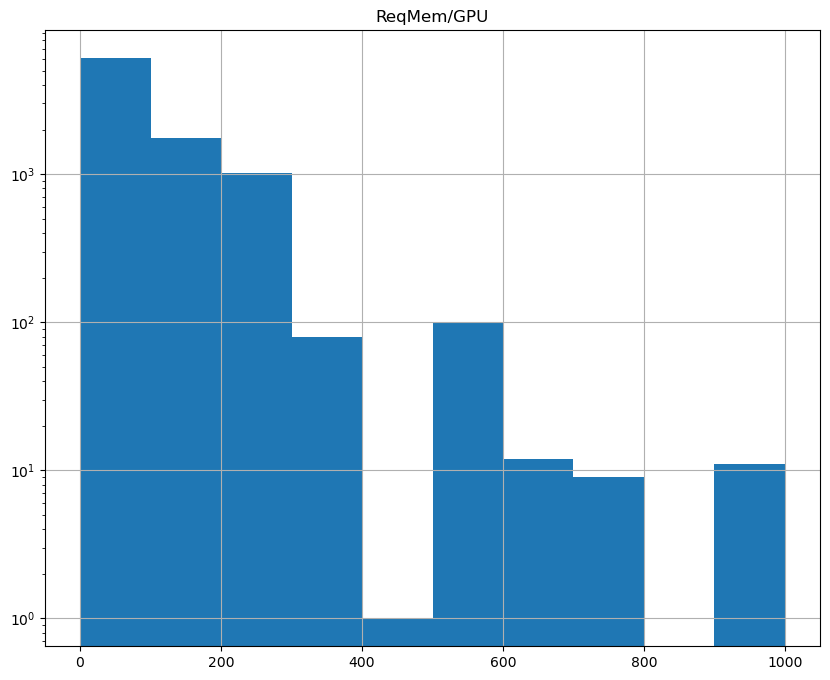

In [30]:
print('** ', numpy.unique(SACCT_obj['NGPUs']))
ix_gpu = SACCT_obj['NGPUs']>0
ix_cpu = numpy.invert(ix_gpu)
#
sacct_gpus = SACCT_obj.jobs_summary[ix_gpu]
#mem_per_gpu= SACCT_server[]
#
print('*** ', len(SACCT_serc.jobs_summary), len(sacct_gpus))
#
mem_per_gpu = (sacct_gpus['ReqMem']/sacct_gpus['NGPUs'])/10**9
mem_per_cpu = (SACCT_obj['ReqMem'][ix_cpu] / SACCT_obj['NCPUS'][ix_cpu])/10**9

req_mem = SACCT_obj['ReqMem']/10**9.
#
fg = plt.figure(figsize=(10,8))
ax1 = fg.add_subplot(1,1,1)
#ax2 = fg.add_subplot(1,2,2)
#
hh_gpu = ax1.hist(mem_per_gpu, bins=10)

##hh_cpu = ax2.hist(mem_per_cpu, bins=20)
#hh_cpu = ax2.hist( (SACCT_obj['ReqMem']/(1024**3)), bins=2)
#
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.grid()
ax2.grid()
#fg.suptitle('Requested Memory', size=16)
ax1.set_title('ReqMem/GPU')

**  [ 0  1  2  3  4  5  6  7  8  9 10 12 15 20 29 32]
***  1693406 9045


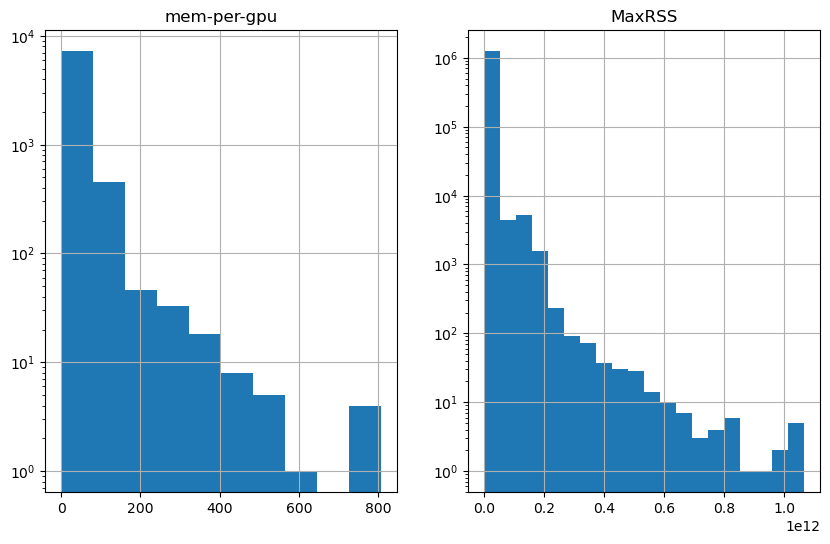

In [31]:
print('** ', numpy.unique(SACCT_obj['NGPUs']))
ix_gpu = SACCT_obj['NGPUs']>0
ix_cpu = numpy.invert(ix_gpu)
#
sacct_gpus = SACCT_obj.jobs_summary[ix_gpu]
#mem_per_gpu= SACCT_server[]
#
print('*** ', len(SACCT_serc.jobs_summary), len(sacct_gpus))
#
mem_per_gpu = (sacct_gpus['MaxRSS']/sacct_gpus['NGPUs'])/10**9
mem_per_cpu = (SACCT_obj['MaxRSS'] / SACCT_obj['NCPUS'])/10**9

req_mem = SACCT_obj['MaxRSS']/1**9.
#
fg = plt.figure(figsize=(10,6))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
hh_gpu = ax1.hist(mem_per_gpu, bins=10)
ax1.set_yscale('log')
ax2.set_yscale('log')


#hh_cpu = ax2.hist(mem_per_cpu, bins=20)
hh_cpu = ax2.hist(SACCT_obj['MaxRSS'], bins=20)
#
ax1.grid()
ax1.set_title('mem-per-gpu')
ax2.set_title('MaxRSS')
ax2.grid()
#fg.suptitle('MaxRSS', size=16)

/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3905: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


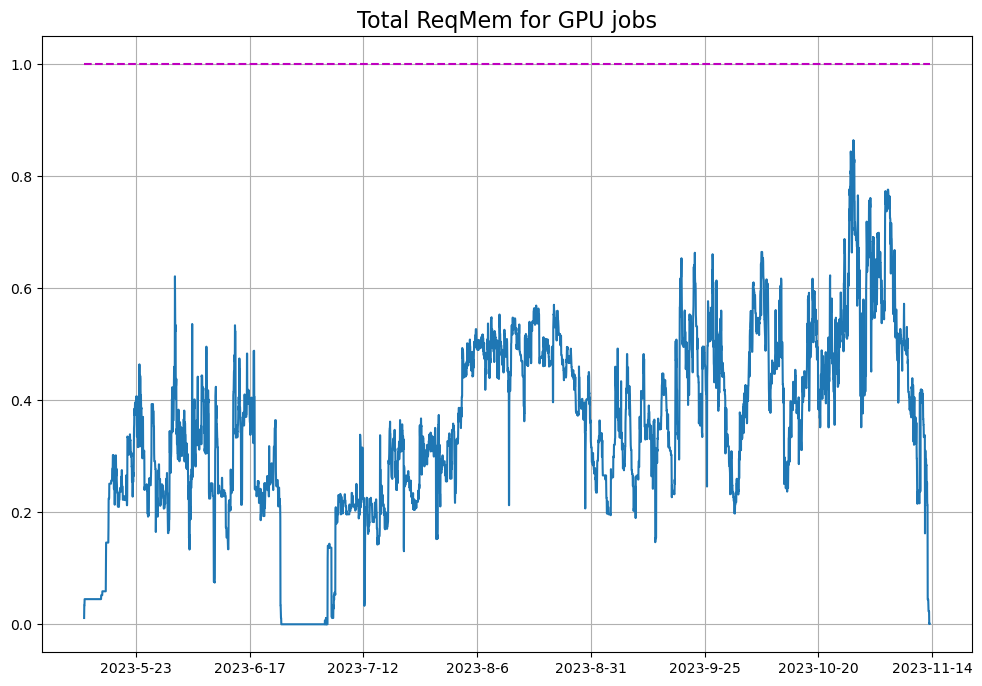

In [32]:
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot(1,1,1)
#
active_req_mem = SACCT_obj.active_jobs_cpu(NCPUs=SACCT_obj['ReqMem'][ix_gpu], jobs_summary=SACCT_obj.jobs_summary[ix_gpu])
ARM = active_req_mem
#
total_mem = 10*1024*1024**3 + 2*192*1024**3
#total_mem = 10*1024*10**9 + 2*192*10**9
#
ax1.plot(ARM['time'], ARM['N_cpu']/total_mem, ls='-')
#
#ax1.plot(ARM['time'][0::len(ARM['time'])-1], numpy.ones(2)*total_mem, ls='--', color='m')
ax1.plot(ARM['time'][0::len(ARM['time'])-1], numpy.ones(2), ls='--', color='m')
ax1.grid()
ax1.set_title('Total ReqMem for GPU jobs', size=16)
lbls = hpc_lib.fg_time_labels_to_dates(ax1)

In [33]:
print('** ', active_req_mem.dtype)

**  [('time', '>f8'), ('N_jobs', '>f8'), ('N_cpu', '>f8')]


### Some Seasonality reports:
NOTE: Some reports being moved to hpc_reports module.

/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1501: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


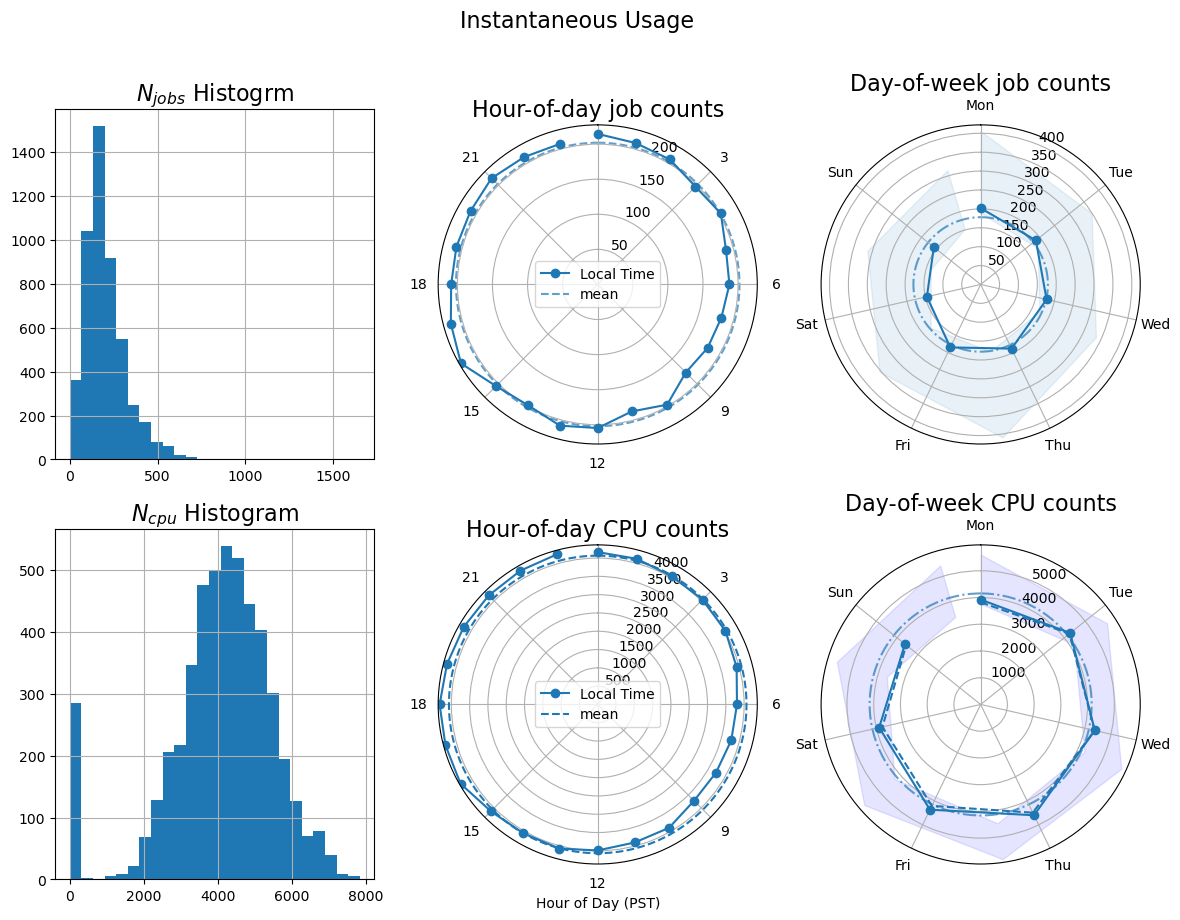

In [34]:
cpu_seasonality = SACCT_obj.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .9], periodic_projection='polar')

In [35]:
SACCT_rep = hpc_reports.SACCT_report_handler(SACCT_obj=SACCT_obj, Short_title='SERC, 2023-4',
                                Full_title="SERC HPC Analytics, April 2023", out_path='output/SERC_202304',
                                            )

*** DEBUG: q_vals [3081.  3918.  4854.  5621.4]
*** DEBUG: q_vals [3578.75 4227.5  5056.   5584.4 ]
*** DEBUG: q_vals [3752.75 4329.   5119.25 5671.1 ]
*** DEBUG: q_vals [3956. 4592. 5230. 5830.]
*** DEBUG: q_vals [3501.5  4300.5  4944.25 5710.  ]
*** DEBUG: q_vals [2874.75 3796.5  4810.25 5597.  ]
*** DEBUG: q_vals [2651.  3586.  4443.  5268.5]
** ** DEBUG:  ['19475', '19500', '19525', '19550', '19575', '19600', '19625', '19650', '19675', '19700']


/home/users/myoder96/Codes/HPC_analytics/hpc_reports.py:258: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)
/home/users/myoder96/Codes/HPC_analytics/hpc_reports.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


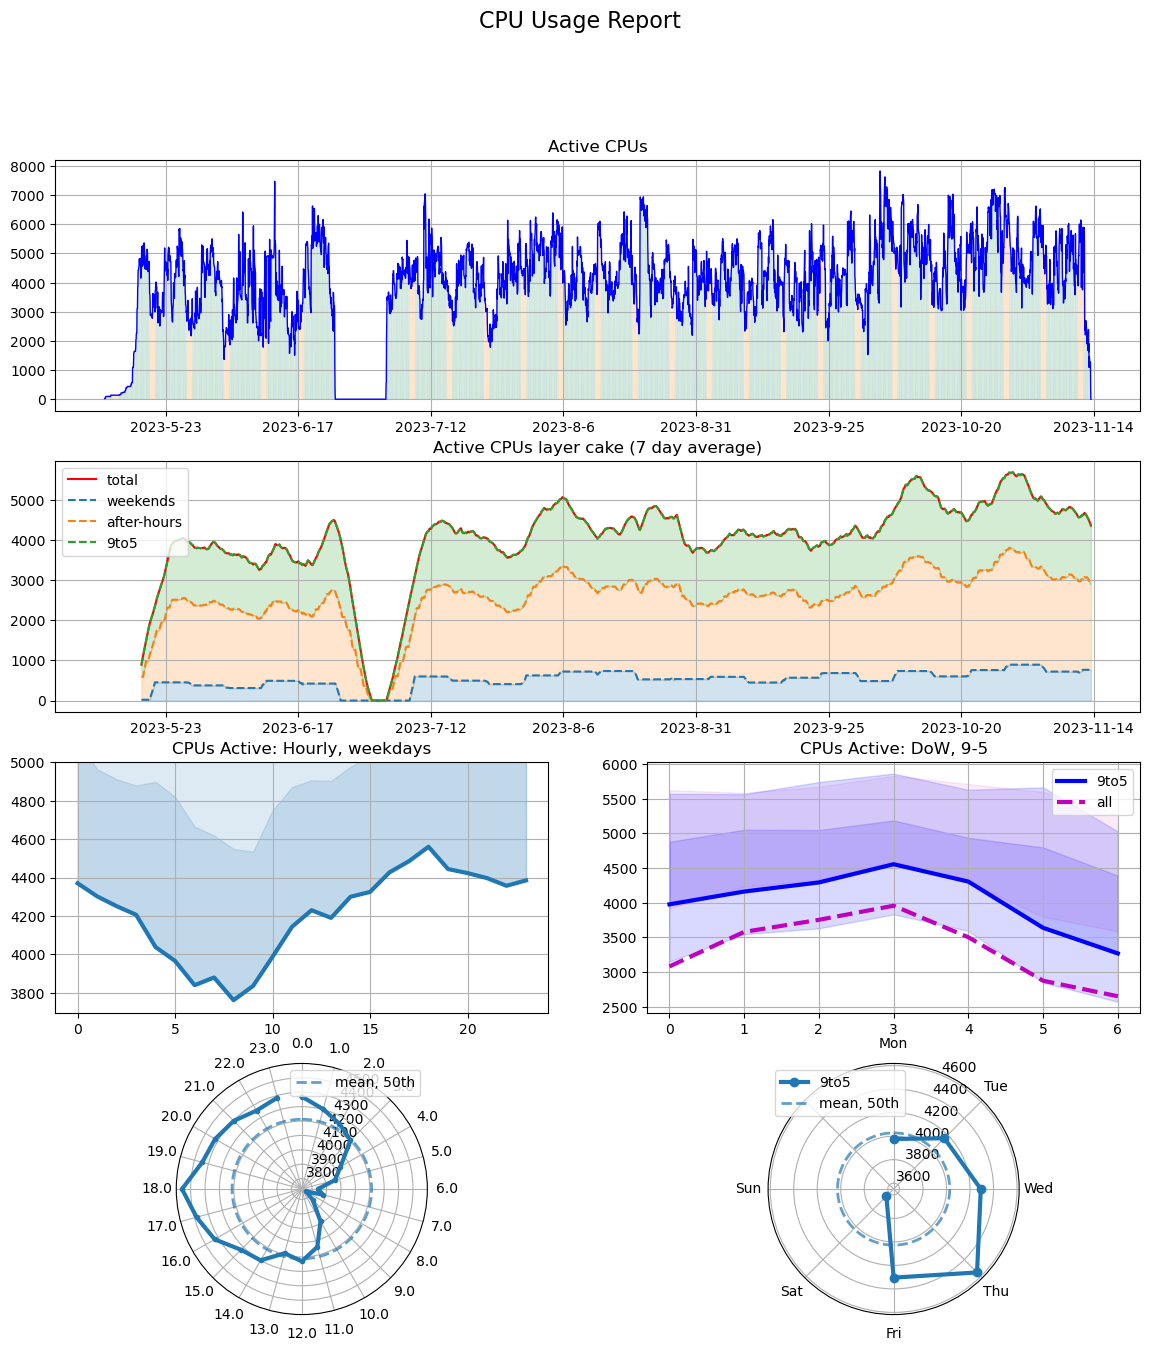

In [36]:
zz = SACCT_rep.cpu_hourly_activity_report()

In [63]:
print(mem_per_cpu[0:500])

[6.67443333e-02 5.23590000e-02 5.79260000e-02 5.20320000e-02
 6.68625833e-02 5.26100000e-02 5.20300000e-02 5.26050000e-02
 5.21620000e-02 5.23910000e-02 5.23140000e-02 5.21040000e-02
 5.21390000e-02 5.27900000e-02 6.12850000e-02 1.10933918e+01
 1.41850423e+01 1.10858370e+01 1.10150253e+01 1.17398500e-02
 6.62319583e-02 1.16448490e+00 3.34070000e-02 3.84695000e-02
 2.97025000e-02 3.20145000e-02 6.30000000e-05 8.54926638e+00
 9.34350844e+00 4.56282981e+00 6.74957083e-02 8.54407625e-01
 1.55267913e+00 8.55673500e-01 8.62691000e-01 8.61457625e-01
 8.56858875e-01 8.66410375e-01 4.98094400e-01 5.81785000e-01
 5.79658000e-01 5.79659000e-01 5.79461000e-01 5.79440000e-01
 5.79436000e-01 5.79440000e-01 5.79337000e-01 5.81672000e-01
 5.79237000e-01 5.79233000e-01 5.80625000e-01 5.81349000e-01
 5.80213000e-01 9.42515000e-02 5.82824000e-01 5.13976500e-01
 1.27404000e-02 1.15817500e-02 1.54300000e-03 4.16157382e+00
 3.39784591e+00 6.61717083e-02 4.68854335e+01 8.68591030e+01
 4.21021450e+00 6.674995

##  A Group report:
- specify group; all partitions.
- This is nominally (a version of) a standard report we might run for a PI group -- or at least this is how we produce the SACCT_obj for that group).

In [64]:
grp_group='oneillm'
grp_partition=None
SACCT_obj_grp = hpc_lib.SACCT_data_direct(group=grp_group, partition=grp_partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose, delim=delim_sacct,
                                          end_date=str(end_date), keep_raw_data=False)

***  2023-05-18 00:00:00+00:00 <class 'datetime.datetime'> 2023-11-14 00:00:00+00:00 <class 'datetime.datetime'>
*** DEBUG: Now execute load_sacct_data(); options_str= --group=oneillm  --delimiter="*" 
*** DEBUG: load_sacct_data() executed. Compute calc_jobs_summary()
*** DEBUG: data stuff:  16731 (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('Account', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('ReqMem', '<f8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('ReqTRES', 'O'), ('AllocTRES', 'O'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 'O'

/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3309: RuntimeWarning: All-NaN slice encountered
  jobs_summary[cls][k] = tuple([f(sub_data[n2]) for (n1, n2, f) in js_col_f])
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: All-NaN slice encountered
  ('NTasks',    'NTasks', lambda x: numpy.nanmax(x).astype(int)),\
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: invalid value encountered in cast
  ('NTasks',    'NTasks', lambda x: numpy.nanmax(x).astype(int)),\


*** DEBUG t_now: 19674.464685664432, t_max: 19674.45658564815


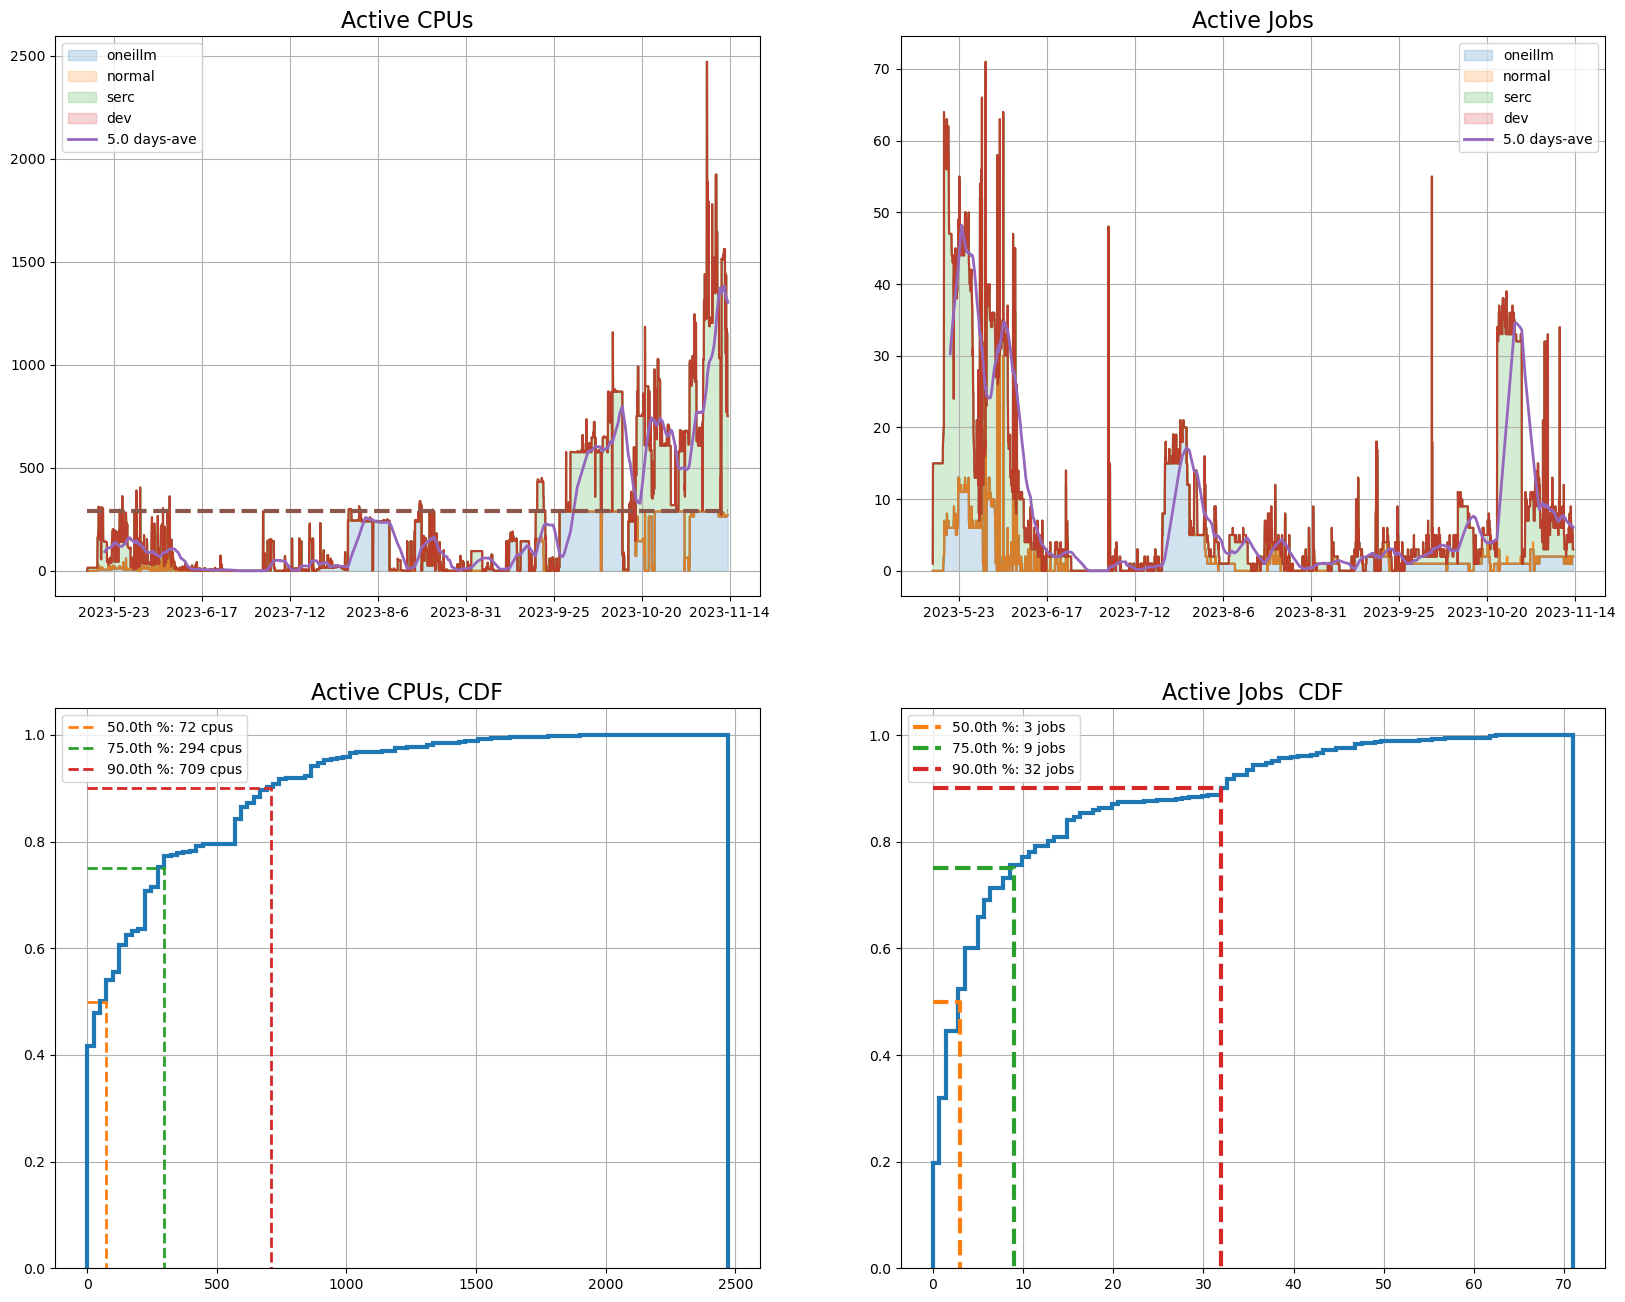

In [65]:
fg_cpu_lc_acct = SACCT_obj_grp.report_activecpus_jobs_layercake_and_CDFs(group_by='Partition')

ax = fg_cpu_lc_acct.axes[0]
ln_ = ax.lines[0]
X = ln_.get_xdata()
#
ax.plot(X[0::(len(X)-1)], (12*24)*numpy.ones(2), ls='--', lw=3)

In [66]:
grp_group='gorelick'
grp_partition=None
SACCT_obj_grp = hpc_lib.SACCT_data_direct(group=grp_group, partition=grp_partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose, delim=delim_sacct,
                                          end_date=str(end_date), keep_raw_data=False)

***  2023-05-18 00:00:00+00:00 <class 'datetime.datetime'> 2023-11-14 00:00:00+00:00 <class 'datetime.datetime'>
*** DEBUG: Now execute load_sacct_data(); options_str= --group=gorelick  --delimiter="*" 
*** DEBUG: load_sacct_data() executed. Compute calc_jobs_summary()
*** DEBUG: data stuff:  3783758 (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('Account', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('ReqMem', '<f8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('ReqTRES', 'O'), ('AllocTRES', 'O'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 

/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3309: RuntimeWarning: All-NaN slice encountered
  jobs_summary[cls][k] = tuple([f(sub_data[n2]) for (n1, n2, f) in js_col_f])
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: invalid value encountered in cast
  ('NTasks',    'NTasks', lambda x: numpy.nanmax(x).astype(int)),\
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: All-NaN slice encountered
  ('NTasks',    'NTasks', lambda x: numpy.nanmax(x).astype(int)),\
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3309: RuntimeWarning: All-NaN slice encountered
  jobs_summary[cls][k] = tuple([f(sub_data[n2]) for (n1, n2, f) in js_col_f])
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: All-NaN slice encountered
  ('NTasks',    'NTasks', lambda x: numpy.nanmax(x).astype(int)),\
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: invalid value encountered in cast
  ('NTasks',    'NTasks', l

*** DEBUG t_now: 19674.476288986098, t_max: 19674.07144675926


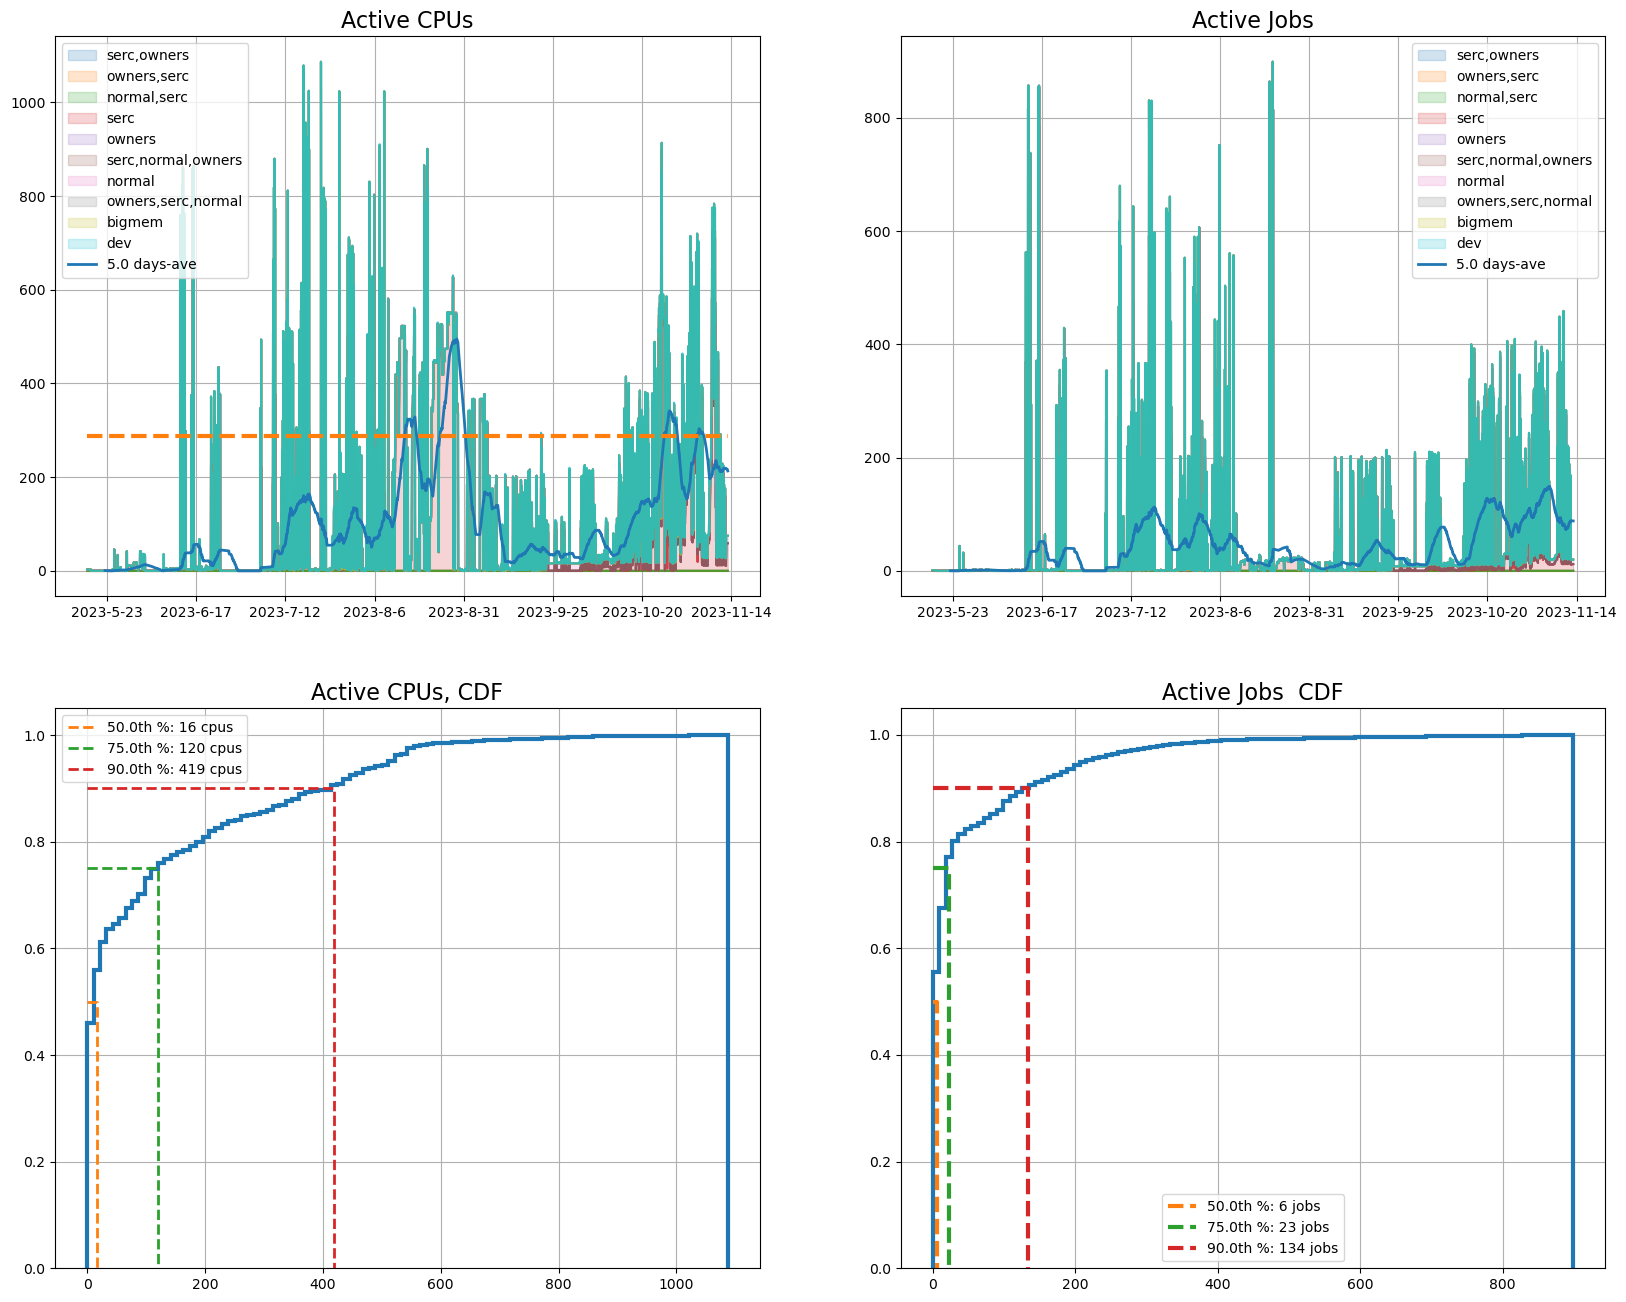

In [67]:
fg_cpu_lc_acct = SACCT_obj_grp.report_activecpus_jobs_layercake_and_CDFs(group_by='Partition')

ax = fg_cpu_lc_acct.axes[0]
ln_ = ax.lines[0]
X = ln_.get_xdata()
#
ax.plot(X[0::(len(X)-1)], (12*24)*numpy.ones(2), ls='--', lw=3)

Text(0.5, 0, '$MaxRSS/ReqMEM$')

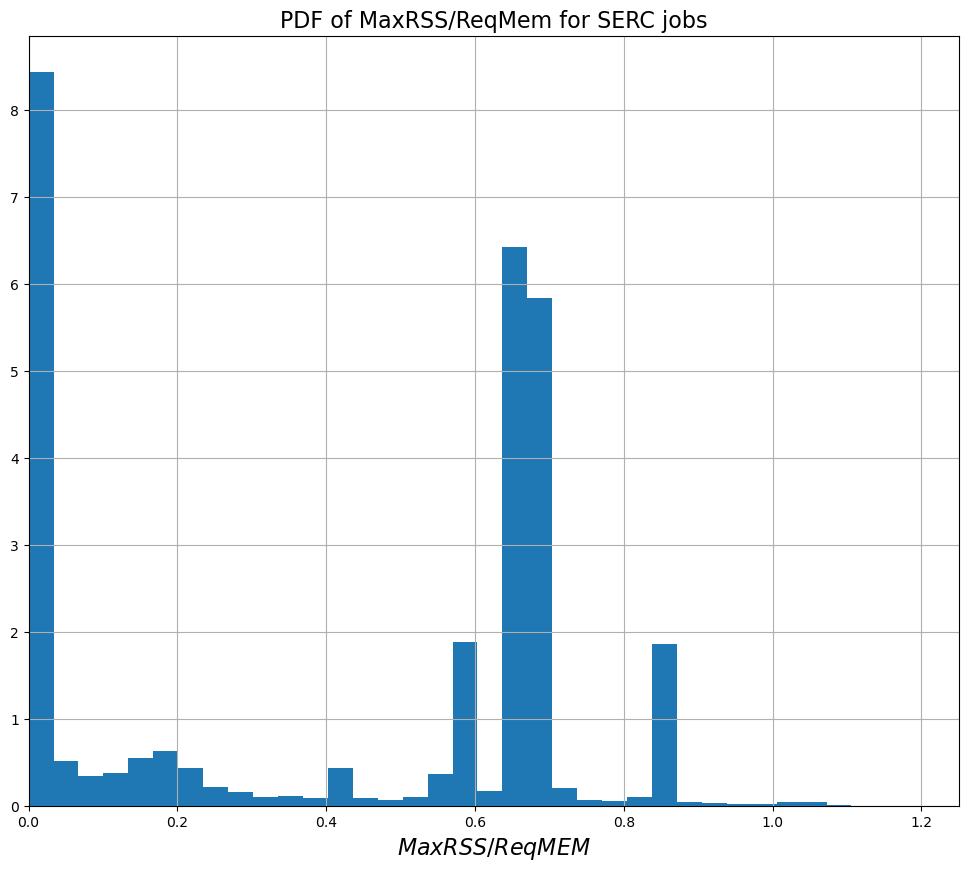

In [68]:
fg = plt.figure(figsize=(12,10))
ax = fg.add_subplot(1,1,1)
#
zz = ax.hist(SACCT_obj['MaxRSS']/SACCT_obj['ReqMem'], bins=100, density=True)
ax.set_xlim(0., 1.25)
ax.grid()
ax.set_title('PDF of MaxRSS/ReqMem for SERC jobs', size=16)
ax.set_xlabel('$MaxRSS/ReqMEM$', size=16)

In [69]:
print('** ', SACCT_obj['ReqMem'][0:20])
print('** ', SACCT_obj['MaxRSS'][0:20])

**  [5.00e+10 2.00e+09 2.00e+09 2.00e+09 5.00e+10 2.00e+09 2.00e+09 2.00e+09
 2.00e+09 2.00e+09 2.00e+09 2.00e+09 2.00e+09 2.00e+09 2.00e+09 1.28e+11
 1.28e+11 1.28e+11 1.28e+11 1.60e+11]
**  [1.6018640e+09 5.2359000e+07 5.7926000e+07 5.2032000e+07 1.6047020e+09
 5.2610000e+07 5.2030000e+07 5.2605000e+07 5.2162000e+07 5.2391000e+07
 5.2314000e+07 5.2104000e+07 5.2139000e+07 5.2790000e+07 6.1285000e+07
 9.9840526e+10 9.9295296e+10 9.9772533e+10 9.9135228e+10 2.3479700e+08]


In [12]:
ix_gpu = SACCT_obj['NGPUs']>0
GPU_jobs = SACCT_obj.jobs_summary[ix_gpu]
#


In [16]:
for rw in GPU_jobs[0:10]:
    print(f'**[{rw["JobID"].decode()}] {rw}')
    

**[18802403] (45, b'hytang', b'lou', b'55535', b'lou', b'18802403', b'18802403', b'serc', b'FAILED', 7., 9, 1.28e+11, 1, 19488.65978009, 19488.65978009, 19488.66040509, 19495.14103009, 6.480625, 2.74092593, 3.30099537, 6.0419213, 1., b'5039334', b'00:00:00', b'billing=48,cpu=1,gres/gpu=1,mem=128G,node=1', b'billing=56,cpu=9,gres/gpu=1,mem=128G,node=1', 9.9840526e+10, 9.9840526e+10, 3.054395e+11, 3.054395e+11, 4.67034e+09, 1.8851167e+11, 4.67034e+09, 1.8851167e+11, b'18802403', 1)
**[18802407] (48, b'hytang', b'lou', b'55535', b'lou', b'18802407', b'18802407', b'serc', b'FAILED', 7., 7, 1.28e+11, 1, 19488.65993056, 19488.65993056, 19488.66295139, 19495.14106481, 6.47809028, 2.67318287, 3.1878588, 5.86104167, 1., b'3917949', b'00:00:00', b'billing=48,cpu=1,gres/gpu=1,mem=128G,node=1', b'billing=54,cpu=7,gres/gpu=1,mem=128G,node=1', 9.9295296e+10, 9.9295296e+10, 2.89451132e+11, 2.89451132e+11, 4.66987e+09, 1.8851026e+11, 4.66987e+09, 1.8851026e+11, b'18802407', 1)
**[18802409] (51, b'hyta